In [1]:
#notebook to create a table of sky subtraction quality metrics from an RSS file of sky subtracted spectra

In [16]:
#need to read in an RSS file, get flux, sky, ivar, wave
#for sky lines, can sum over flux in sky, then flux in flux (sky sub) to find frac that was removed
#measure cont
#for science lines areas, could fit gaussians to sky lines in sky, use as template to see how much sky was removed
#for science lines aread, come up with a way to convert sky line residual into an uncertainty on the sci line
#relate sky line residual with ivar (assuming ivar is correct)
#knox's method which says, flux-sky line residual flux in the shape of the sky (after background removal), frac error- flux/skyflux
#any other metrics for now?
#faintness limit for detecting science line
#sky line and cont metrics can be same lines/areas as before (no need to change at this point)
#then need to save all metrics per spectrum in a nice table

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table,vstack
from scipy.optimize import bisect
from astropy.stats import sigma_clip
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from pathlib import Path


Science lines affected by sky:
    [OI] 6300, 6363 Å – tracers of shocks and ionization fronts

    [NI] 5198, 5200 Å – also tracers of shocks and ionization fronts; useful for density diagnostics and continuum fluorescence

    [OII] 7320, 7330 Å – auroral lines sensitive to electron temperature

    HeI 7281 Å – singlet line sensitive to deviations from Case B and to temperature

    HI 8863, 9015, 9229, 9545 Å – Paschen lines useful for reddening maps

    [SIII] 9069, 9531 Å – critical for determining temperature and S++ abundance

    [Cl II] 9123 Å – ionic abundance of Cl+

    [Cl IV] 8045 Å – ionic abundance of Cl³⁺

    [FeII] 8617 Å – ionic abundance of Fe⁺

    [CI] 8727 Å – recombination/auroral line of neutral carbon

In [22]:
#RSS file input, using old summary file as example

#input_XSframe = 'XSframe_3500_25000_1.fits' # from the SkySprint directory but based on old v1.1.0 data
# https://data.sdss5.org/sas/sdsswork/users/u6046038/lvm/SkySprint/XSframe_3500_25000_1.fits

#input_XSframe = 'XSframe_4000_30000_1.fits' # used by Amy, I don't find this anywhere?

input_XSframe = 'XSFrame_1.1.1_3469_31300_1_50.fits'
out_dir = input_XSframe[:input_XSframe.find('fits')-1]
# https://data.sdss5.org/sas/sdsswork/users/u6046038/lvm/MedCombined/XSFrame_1.1.1_3469_31300_1_50.fits

fits.info(input_XSframe)

with fits.open(input_XSframe) as hdul:
    wave=hdul['WAVE'].data
    flux=hdul['FLUX'].data
    sky=hdul['SKY'].data
    ivar=hdul['ivar'].data
    drpall = Table(hdul['DRP_ALL'].data)

Filename: XSFrame_1.1.1_3469_31300_1_50.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  WAVE          1 ImageHDU         7   (12401,)   float32   
  2  FLUX          1 ImageHDU        20   (12401, 7947)   float32   
  3  SKY           1 ImageHDU        20   (12401, 7947)   float32   
  4  IVAR          1 ImageHDU        20   (12401, 7947)   float32   
  5  DRP_ALL       1 BinTableHDU    107   7947R x 49C   [6A, K, K, K, D, K, K, K, 5A, K, 24A, 23A, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, D, 23A, 77A, 65A, K, 7A, 8A, 8A, D]   


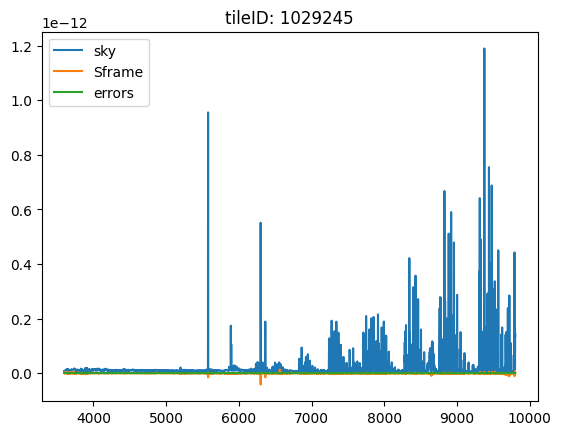

In [3]:
#test plots to make sure wave, sky, flux, and ivar look ok
expID = 500
exp = drpall[expID]

plt.plot(wave,sky[expID],label='sky',zorder=1)
plt.plot(wave,flux[expID],label='Sframe',zorder=2)
plt.plot(wave,1/np.sqrt(ivar[expID]),label='errors',zorder=3)
plt.title(f"tileID: {exp['tileid']}")
#plt.ylim(-0.1e-12,0.5e-12)
plt.legend()

In [136]:
#names of sky lines and cont regions
sky_list=['[OI]5577', '[OI]6300', '[OH]6865', '[Na]5891', 'O2', 'AirglowCont', 'Bcont', 'Rcont', 'Zcont']
#lrangelist=[(5574, 5580), (6298,6304), (6862,6868), (5888, 5898), (8630, 8670), (5420, 5440), (4195, 4220), (6420, 6440), (9130, 9145)] # original from Amy
lrangelist=[(5575, 5580), (6298,6302), (6861,6866), (5887, 5898), (8610, 8710), (5420, 5440), (4195, 4220), (6420, 6440), (9130, 9145)]
#extened range around the line for background cont subtraction where -999 means no cont subtraction done
#crangelist=[(5571, 5583), (6295, 6307), (6859, 6871), (5885, 5901), (-999, -999), (-999, -999), (-999, -999), (-999, -999), (-999, -999)] # original from Amy
crangelist=[(5571, 5583), (6289, 6305), (6853, 6868), (5880, 5901), (8600, 8724), (-999, -999), (-999, -999), (-999, -999), (-999, -999)]

#names of the science lines of interest
sci_lines=['[NI]5198','[NI]5200','[OII]7320','[OII]7330','HeI7281','HI8863','HI9015','HI9229','HI9545','[SIII]9069','[SIII]9531','[ClII]9123','[ClIV]8045','[FeII]8617','[CI]8727']
#wave location of those science lines
sci_lines_wave=[5198, 5200, 7320, 7330, 7281, 8863, 9015, 9229, 9545, 9069, 9531, 9123, 8045, 8617, 8727]
#OH and O2 should check wavelengths

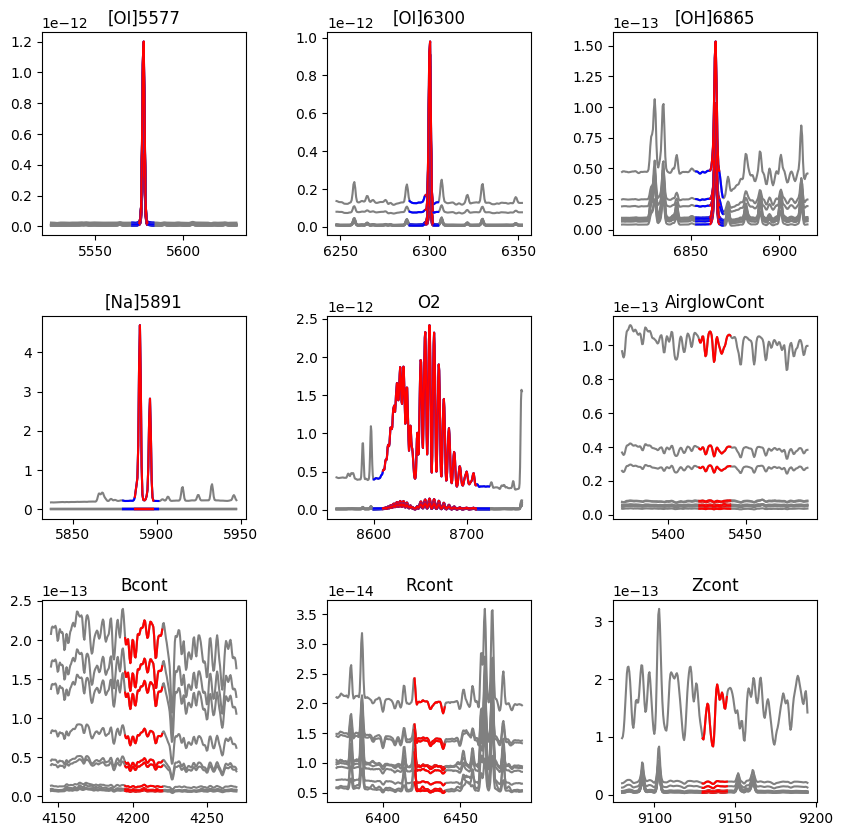

In [169]:
# Do some plots & checks of the selected line regions and continuum regions

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
axsF = axs.flatten()

for which_line,nn in enumerate(sky_list):
    
    sub = (wave>=lrangelist[which_line][0]-50) & (wave<=lrangelist[which_line][1]+50) # line range selection
    sub_line = (wave>=lrangelist[which_line][0]) & (wave<=lrangelist[which_line][1]) # line range selection
    sub_cont = (wave>=crangelist[which_line][0]) & (wave<=crangelist[which_line][1]) # line range selection
    
    # 10 randomly selected spectra    
    for ii in np.random.randint(0, len(drpall)-1, size=10): #np.arange(100,110):
        axsF[which_line].plot(wave[sub], flux[ii,:][sub]+sky[ii,:][sub],label='flux+sky',color='grey') # spectrum    
        axsF[which_line].plot(wave[sub_cont], flux[ii,:][sub_cont]+sky[ii,:][sub_cont],label='flux+sky',color='blue') # cont
        axsF[which_line].plot(wave[sub_line], flux[ii,:][sub_line]+sky[ii,:][sub_line],label='flux+sky',color='red')  # line
    
    axsF[which_line].set_title(sky_list[which_line])

out_path = Path(out_dir+'/sky_lines_list.png')
# Make sure the directory exists
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path)


In [140]:
#calculate sky line residual flux and sky line residual flux over sky line flux
#sky line residual flux over error
#for a single median exposure

#loops over all the sky lines/regions to get metrics for a given flux, sky, ivar
def sky_line_metrics(wave, flux, sky, ivar, sky_line_list, lrangelist, crangelist):
    resid_mean_list = [] #mean flux of the sky line residual
    resid_med_list = [] #median flux of the sky line residual
    resid_std_list = [] #standard deviation of the sky line residual
    sky_mean_list = [] #mean of the sky flux (before sky subtraction)
    sky_med_list = [] #median of sky flux (before sky subtraction)
    sky_std_list = [] #standard deviation of sky flux (before sky subtraction)
    error_med_list = [] #median of the error after sky subtraction
    resid_sky_list = [] #residual flux over sky flux (like Knox's frac_error)
    resid_error_list = [] #residual flux over error

    for j in range(len(sky_list)):
        wvl, wvc = line_windows(lrangelist[j], crangelist[j], wave)
        resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error = line_stats(flux, sky, ivar, wvl, wvc)
        resid_mean_list.append(resid_mean)
        resid_med_list.append(resid_med)
        resid_std_list.append(resid_std)
        sky_mean_list.append(sky_mean)
        sky_med_list.append(sky_med)
        sky_std_list.append(sky_std)
        error_med_list.append(error_med)
        resid_sky_list.append(resid_sky)
        resid_error_list.append(resid_error)
    
    return resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list

#converts lrange and crange into wavelengths for each
def line_windows(lrange, crange, wave):
    wave_line = (wave>=lrange[0]) & (wave<=lrange[1]) # line range selection
    #ignores cont if crange is -999, and sets to -999
    if crange[0] == -999:
        wave_cont = [-999]
    else:
        wave_cont = ((wave>=crange[0]) & (wave<lrange[0])) | ((wave>lrange[1]) & (wave<=crange[1])) # cont range selection
    return wave_line, wave_cont

#calculates the sky line/region metrics
def line_stats(flux, sky, ivar, wave_line, wave_cont):
    #subtracting the average background cont if not -999
    if wave_cont[0] == -999:
        norm_line_flux = flux[wave_line]
        norm_line_sky = sky[wave_line]
    else:
        norm_line_flux = flux[wave_line]-np.nanmedian(flux[wave_cont])
        norm_line_sky = sky[wave_line]-np.nanmedian(sky[wave_cont])
        
    #rel_line_flux = norm_line_flux * np.sqrt(ivar[wave_line])
    resid_mean = np.nanmean(norm_line_flux)
    resid_med = np.nanmedian(norm_line_flux)
    resid_std = np.nanstd(norm_line_flux)
    sky_mean = np.nanmean(norm_line_sky) #for the sky fluxes, should these be sums? for regions its ok, but for lines??
    sky_med = np.nanmedian(norm_line_sky)
    sky_std = np.nanstd(norm_line_sky)
    error_med = np.nanmedian(1./np.sqrt(ivar[wave_line]))
    resid_sky = resid_med / sky_med #should this be done per pixel?
    resid_error = resid_med / error_med
    return resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error

In [141]:
resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list = sky_line_metrics(wave, flux[100], sky[100], ivar[100], sky_list, lrangelist, crangelist)

In [142]:
#testing if the line stats work, and looks ok!
for j in range(len(sky_list)):
    print(sky_list[j], resid_med_list[j], sky_med_list[j], error_med_list[j], resid_sky_list[j], resid_error_list[j])

[OI]5577 1.13875745e-14 9.7539435e-14 3.4253515e-16 0.116748415 33.24498
[OI]6300 2.3928464e-14 8.2228414e-14 2.537414e-16 0.29099995 94.30256
[OH]6865 -4.3426109e-16 1.0743698e-14 1.680993e-16 -0.040420074 -2.5833604
[Na]5891 -8.2634115e-16 5.8677835e-15 2.0220644e-16 -0.14082679 -4.0866213
O2 -2.0996856e-16 7.174735e-15 8.779665e-17 -0.029264992 -2.3915327
AirglowCont 1.8358296e-15 1.4774232e-13 2.6525506e-16 0.012425888 6.920997
Bcont -5.007518e-16 2.3742474e-13 4.195246e-16 -0.0021090969 -1.1936172
Rcont 1.6393616e-15 9.9965534e-14 1.6415422e-16 0.016399268 9.986716
Zcont 6.832159e-16 3.132586e-14 8.0440793e-17 0.021809964 8.493401


In [143]:
#set of metrics to determine sky sub quality at a given sci line wave
#per single median expsoure (one wave, flux, sky, and ivar)
#average sky line residuals flux and std
#sky line residuals over sky flux
#sky line residuals are only useful when looking at sky sub of sky spectra or known source

#more sophistcated approach would be to find where sky flux is in sky and see how well those pixels are subtracted, in these regions I am assuming there will be multiple sky lines present
def science_line_metrics(wave, flux, sky, ivar, sci_lines_wave):
    
    resid_mean_list = [] #mean flux of the sky line residual
    resid_med_list = [] #median flux of the sky line residual
    resid_std_list = [] #standard deviation of the sky line residual
    sky_mean_list = [] #mean of the sky flux (before sky subtraction)
    sky_med_list = [] #median of sky flux (before sky subtraction)
    sky_std_list = [] #standard deviation of sky flux (before sky subtraction)
    error_med_list = [] #median of the error after sky subtraction
    resid_sky_list = [] #residual flux over sky flux (like Knox's frac_error)
    resid_error_list = [] #residual flux over error
    sum_sky_flux_list = [] #total flux from sky before sky subtraction in flagged sky pixels
    sum_skyresid_flux_list = [] #totol flux in residuals after sky subtraction in flagged sky pixels
    skyresid_sky_list = [] #ratio of total flux in residuals over sky from flagged sky pixels

    for j in range(len(sci_lines_wave)):
        wave_region = (wave>=sci_lines_wave[j]-3) & (wave<=sci_lines_wave[j]+3) #defining a 6Ang wide region centered on sci line
        #getting same stats as for the sky lines, but now for the sci lines and no background sub since its region
        resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error = line_stats(flux, sky, ivar, wave_region, [-999])
        resid_mean_list.append(resid_mean)
        resid_med_list.append(resid_med)
        resid_std_list.append(resid_std)
        sky_mean_list.append(sky_mean)
        sky_med_list.append(sky_med)
        sky_std_list.append(sky_std)
        error_med_list.append(error_med)
        resid_sky_list.append(resid_sky)
        resid_error_list.append(resid_error)
        #getting stats of the more sophisticated approach
        sum_sky_flux, sum_skyresid_flux, skyresid_sky = sci_region_stats(wave_region, flux, sky)
        sum_sky_flux_list.append(sum_sky_flux)
        sum_skyresid_flux_list.append(sum_skyresid_flux)
        skyresid_sky_list.append(skyresid_sky)
        
    
    return resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list, sum_sky_flux_list, sum_skyresid_flux_list, skyresid_sky_list


def find_sky(wave_region, sky):
    background = np.nanpercentile(abs(sky[wave_region]),10) #doing abs() in case of absorption features
    wave_sky = sky[wave_region] > background #should flag all sky emission in region
    return wave_sky
    
def sci_region_stats (wave_region, flux, sky):
    wave_sky = find_sky(wave_region, sky)
    sum_sky_flux = np.sum(sky[wave_region][wave_sky]) #total flux from sky before sky subtraction
    sum_skyresid_flux = np.sum(flux[wave_region][wave_sky]) #total flux from sky residuals (after sky subtraction)
    skyresid_sky = sum_skyresid_flux / sum_sky_flux #ratio of the residuals over sky in flagged sky pixels
    return sum_sky_flux, sum_skyresid_flux, skyresid_sky

In [144]:
resid_mean_sci, resid_med_sci, resid_std_sci, sky_mean_sci, sky_med_sci, sky_std_sci, error_med_sci, resid_sky_sci, resid_error_sci, sum_sky_flux_sci, sum_skyresid_flux_sci, skyresid_sky_sci = science_line_metrics(wave, flux[100], sky[100], ivar[100], sci_lines_wave)

In [145]:
#testing if the line stats work, and looks ok!
for j in range(len(sci_lines)):
    print(sci_lines[j], resid_med_sci[j], sky_med_sci[j], error_med_sci[j], resid_sky_sci[j], resid_error_sci[j], sum_sky_flux_sci[j], sum_skyresid_flux_sci[j], skyresid_sky_sci[j])

[NI]5198 6.2928465e-16 1.7474508e-13 2.9644536e-16 0.003601158 2.1227677 1.9014575e-12 7.264341e-15 0.0038204067
[NI]5200 6.2928465e-16 1.7474508e-13 2.9644536e-16 0.003601158 2.1227677 1.9200004e-12 8.3553735e-15 0.004351756
[OII]7320 9.653599e-16 7.047243e-14 1.3862414e-16 0.013698405 6.9638653 8.335689e-13 1.1162941e-14 0.013391744
[OII]7330 7.2655966e-16 7.0704774e-14 1.3806112e-16 0.010275964 5.262594 9.107403e-13 -1.9738632e-14 -0.021673173
HeI7281 1.2328522e-15 7.370848e-14 1.4302554e-16 0.016726056 8.619805 8.539066e-13 1.150976e-14 0.013478944
HI8863 5.729993e-16 3.9971326e-14 8.640745e-17 0.014335259 6.6313643 4.4862735e-13 6.496491e-15 0.014480818
HI9015 6.547151e-16 3.145753e-14 8.015542e-17 0.020812668 8.16807 3.4863486e-13 6.662823e-15 0.019111179
HI9229 5.7525824e-16 3.0259425e-14 8.345853e-17 0.019010877 6.8927436 3.4399263e-13 6.400824e-15 0.018607445
HI9545 4.2822545e-16 2.0482578e-14 8.143399e-17 0.020906813 5.2585588 2.3046249e-13 4.660332e-15 0.02022165
[SIII]9069 

In [146]:
#need to loop over all median spectra/expnums and print to nice table...

In [147]:
def run_one_expnum(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave):
    
    resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list = sky_line_metrics(wave, flux, sky, ivar, sky_list, lrangelist, crangelist)
    resid_mean_sci, resid_med_sci, resid_std_sci, sky_mean_sci, sky_med_sci, sky_std_sci, error_med_sci, resid_sky_sci, resid_error_sci, sum_sky_flux_sci, sum_skyresid_flux_sci, skyresid_sky_sci = science_line_metrics(wave, flux, sky, ivar, sci_lines_wave)

    row = []
    for j in range(len(sky_list)):
        row.append(resid_mean_list[j])
        row.append(resid_med_list[j])
        row.append(resid_std_list[j])
        row.append(sky_mean_list[j])
        row.append(sky_med_list[j])
        row.append(sky_std_list[j]) 
        row.append(error_med_list[j])
        row.append(resid_sky_list[j])
        row.append(resid_error_list[j])
    for j in range(len(sci_lines)):
        row.append(resid_mean_sci[j])
        row.append(resid_med_sci[j])
        row.append(resid_std_sci[j])
        row.append(sky_mean_sci[j])
        row.append(sky_med_sci[j])
        row.append(sky_std_sci[j]) 
        row.append(error_med_sci[j])
        row.append(resid_sky_sci[j])
        row.append(resid_error_sci[j])
        row.append(sum_sky_flux_sci[j])
        row.append(sum_skyresid_flux_sci[j])
        row.append(skyresid_sky_sci[j])

    return row

def run_RSS(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave):

    column_names = []
    for j in range(len(sky_list)):
        column_names.append(f"{sky_list[j]}_resid_mean")
        column_names.append(f"{sky_list[j]}_resid_med")
        column_names.append(f"{sky_list[j]}_resid_std")
        column_names.append(f"{sky_list[j]}_sky_mean")
        column_names.append(f"{sky_list[j]}_sky_med")
        column_names.append(f"{sky_list[j]}_sky_std") 
        column_names.append(f"{sky_list[j]}_error_med")
        column_names.append(f"{sky_list[j]}_resid_sky")
        column_names.append(f"{sky_list[j]}_resid_error")
    for j in range(len(sci_lines)):
        column_names.append(f"{sci_lines[j]}_resid_mean")
        column_names.append(f"{sci_lines[j]}_resid_med")
        column_names.append(f"{sci_lines[j]}_resid_std")
        column_names.append(f"{sci_lines[j]}_sky_mean")
        column_names.append(f"{sci_lines[j]}_sky_med")
        column_names.append(f"{sci_lines[j]}_sky_std") 
        column_names.append(f"{sci_lines[j]}_error_med")
        column_names.append(f"{sci_lines[j]}_resid_sky")
        column_names.append(f"{sci_lines[j]}_resid_error")
        column_names.append(f"{sci_lines[j]}_sum_sky_flux")
        column_names.append(f"{sci_lines[j]}_sum_skyresid_flux")
        column_names.append(f"{sci_lines[j]}_skyresid_sky")

    metrics_tab = Table(names=column_names)

    #here loop over all expnums
    for i in range(flux.shape[0]):
        new_row = run_one_expnum(wave, flux[i], sky[i], ivar[i], sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave)
        metrics_tab.add_row(new_row)

    return metrics_tab

In [148]:
tab=run_RSS(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave)

/var/folders/3f/jd4g1rjd4hbgknq2l_3x82yr0000gp/T/ipykernel_1997/1740726013.py:59: RuntimeWarning: divide by zero encountered in divide
  error_med = np.nanmedian(1./np.sqrt(ivar[wave_line]))
/var/folders/3f/jd4g1rjd4hbgknq2l_3x82yr0000gp/T/ipykernel_1997/1740726013.py:60: RuntimeWarning: invalid value encountered in scalar divide
  resid_sky = resid_med / sky_med #should this be done per pixel?
/var/folders/3f/jd4g1rjd4hbgknq2l_3x82yr0000gp/T/ipykernel_1997/2940138764.py:55: RuntimeWarning: invalid value encountered in scalar divide
  skyresid_sky = sum_skyresid_flux / sum_sky_flux #ratio of the residuals over sky in flagged sky pixels


In [149]:
tab

<Table length=7947>
  [OI]5577_resid_mean      [OI]5577_resid_med   ... [CI]8727_skyresid_sky
        float64                 float64         ...        float64       
----------------------- ----------------------- ... ---------------------
 4.3364681826972215e-15  3.0678970072640834e-15 ...    0.2547617554664612
-2.6918012496724916e-14   -4.33351627287604e-15 ...    0.4510056674480438
-2.2829398012855565e-14  -4.095779535570176e-15 ...   0.41322728991508484
-1.7434762062339647e-14 -3.4955366255202307e-16 ...   0.49037599563598633
 1.2187656381345852e-14  1.0634884899801689e-14 ...   0.44620323181152344
-1.0250757152287758e-14  -9.281098821742979e-17 ...    0.5017427802085876
   0.012971845455467701     0.01268313080072403 ...   0.20382386445999146
 0.00030447394237853587    0.011226853355765343 ...   0.17732882499694824
    -0.0567801296710968    0.004332643002271652 ...    0.2087630033493042
                    ...                     ... ...                   ...
  1.041462584032947e-13    4.58545758330077e-14 ...  -0.03793379291892052
 1.7234142308782466e-14  1.2298477089966921e-14 ...  -0.01237627025693655
  -5.09012963885707e-14 -1.5453099683118005e-14 ...  0.006907027680426836
 -6.471982915952704e-14 -2.1193977291483063e-14 ...   0.03564042970538139
  2.749895851392875e-14   1.648049813209474e-14 ...   0.05958244204521179
  4.714099187505712e-14  1.7919012492350825e-14 ...  -0.03865459933876991
 1.3738558461175426e-14  4.4326394564955275e-15 ... -0.013405019417405128
  4.992443531335895e-15  1.3783487629796635e-15 ... -0.024273309856653214
 -3.051000764609169e-16 -1.1237099067278131e-16 ...  -0.07269532233476639
   7.90516266270698e-14   3.895782012416048e-14 ...   0.08848755806684494

In [150]:
# save the table

out_path = Path(out_dir + '/'+'skysub_metrics.dat')
# Make sure the directory exists
out_path.parent.mkdir(parents=True, exist_ok=True)
ascii.write(tab, out_path, overwrite=True, format='fixed_width')

In [249]:
def make_plot(which_line, tab,wave,flux,sky,sci_tiles,out_dir,flag_sci=False):
# 'resid_mean', 'resid_med', 'resid_std', ' sky_mean" (or med), 'resid_sky', ' resid_error' 
# and then for the science lines also the 'sum_sky_flux', 'sum_skyresid_flux', 'skyresid_sky'.  
    
    metrics=["resid_mean",
            "resid_med",
            "resid_std",
            "sky_mean",
#            "sky_med",
#            "sky_std", 
            ]
    
    metrics2 = [ "error_med",
            "resid_sky",
            "resid_error"]

    metrics3 = ['sum_sky_flux', 'sum_skyresid_flux', 'skyresid_sky']

    if flag_sci:
        fig,axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 13),gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
    else:
        fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
    axsF = axs.flatten()

#    if (np.std(tab[which_line+'_'+metrics[0]][sci_tiles]) > 1e-13):
#        xlim = .2e-12
#    else:
#        xlim = .2e-13
    xlim = .2e-13
    
    for i,mm in enumerate(metrics):
        which_metric = which_line+'_'+mm
        bins = np.arange(-1*xlim, xlim, xlim/1e2)#.2e-12,.2e-12,1e-14)
        if mm == 'sky_mean':
            bins *= 10.
        _ = axsF[i].hist(tab[which_metric][sci_tiles],bins=bins)
        axsF[i].set_title(which_metric)
        #plt.plot(tab['[OI]5577_resid_mean'][sci_tiles])
        #plt.ylim(-1e-12,1e-12)    


    mm = metrics2[1]
    which_metric = which_line+'_'+mm
    bins = np.arange(-1,1,.1)
    _ = axsF[4].hist(tab[which_metric][sci_tiles],bins=bins)
    axsF[4].set_title(which_metric)
    
    mm = metrics2[2]
    which_metric = which_line+'_'+mm
    bins = np.arange(-100,100,1)
    _ = axsF[5].hist(tab[which_metric][sci_tiles],bins=bins)
    axsF[5].set_title(which_metric)
#    else:
#        fig.delaxes(axsF[-2])
#        fig.delaxes(axsF[-1])

    if flag_sci:
        mm = metrics3[0]
        which_metric = which_line+'_'+mm
        bins = np.arange(-.2e-12,.2e-12,1e-14)#-.2e-15,.2e-15,1e-17)
        _ = axsF[6].hist(tab[which_metric][sci_tiles],bins=bins)
        axsF[6].set_title(which_metric)

        mm = metrics3[1]
        which_metric = which_line+'_'+mm
        bins = np.arange(-.2e-12,.2e-12,1e-14)
        _ = axsF[7].hist(tab[which_metric][sci_tiles],bins=bins)
        axsF[7].set_title(which_metric)

        mm = metrics3[2]
        which_metric = which_line+'_'+mm
        bins = np.arange(0,5,.1)#-.2e-15,.2e-15,1e-17)
        _ = axsF[8].hist(tab[which_metric][sci_tiles],bins=bins)
        axsF[8].set_title(which_metric)

    # plot some sample spectra
    dist = tab[which_line + '_resid_mean'][sci_tiles]
    dist_median = np.nanmedian(dist)
    dist_sigma = np.nanstd(dist)
    flux_sub = flux[sci_tiles,:]
    sky_sub = sky[sci_tiles,:]
    tab_sub = tab[sci_tiles]

    # Find index of closest value
    idx_median = np.abs(tab_sub[which_line + '_resid_mean'] - dist_median).argmin()
    idx_1sig = np.abs(tab_sub[which_line + '_resid_mean'] - (1.*dist_sigma)).argmin()
    idx_m1sig = np.abs(tab_sub[which_line + '_resid_mean'] - (-1.*dist_sigma)).argmin()

# sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave are not global...
    if flag_sci:
        ii = sci_lines.index(which_line)
        sub = (wave>=sci_lines_wave[ii]-20) & (wave<=sci_lines_wave[ii]+20) # line range selection
        sub_line = (wave>=sci_lines_wave[ii]-3) & (wave<=sci_lines_wave[ii]+3) # line range selection
    else:
        ii = sky_list.index(which_line)
        sub = (wave>=lrangelist[ii][0]-20) & (wave<=lrangelist[ii][1]+20) # line range selection
        sub_line = (wave>=lrangelist[ii][0]) & (wave<=lrangelist[ii][1]) # line range selection
    
    # 10 randomly selected spectra    
    axsF[-3].plot(wave[sub], flux_sub[idx_median,:][sub]+sky_sub[idx_median,:][sub],label='obs',color='grey') # spectrum    
    axsF[-3].plot(wave[sub], flux_sub[idx_median,:][sub],label='sky subtracted',color='k') # spectrum    
    axsF[-3].plot(wave[sub_line], flux_sub[idx_median,:][sub_line]+sky_sub[idx_median,:][sub_line],label='sky line',color='red')  # line
    axsF[-3].set_title("median (in "+ which_line + '_resid_mean)')
    axsF[-3].legend()

    axsF[-2].plot(wave[sub], flux_sub[idx_1sig,:][sub]+sky_sub[idx_1sig,:][sub],label='flux+sky',color='grey') # spectrum    
    axsF[-2].plot(wave[sub], flux_sub[idx_1sig,:][sub],label='flux',color='k') # spectrum    
    axsF[-2].plot(wave[sub_line], flux_sub[idx_1sig,:][sub_line]+sky_sub[idx_1sig,:][sub_line],label='flux+sky',color='red')  # line
    axsF[-2].set_title(r"1$\sigma$")

    axsF[-1].plot(wave[sub], flux_sub[idx_m1sig,:][sub]+sky_sub[idx_m1sig,:][sub],label='flux+sky',color='grey') # spectrum    
    axsF[-1].plot(wave[sub], flux_sub[idx_m1sig,:][sub],label='flux',color='k') # spectrum    
    axsF[-1].plot(wave[sub_line], flux_sub[idx_m1sig,:][sub_line]+sky_sub[idx_m1sig,:][sub_line],label='flux+sky',color='red')  # line
    axsF[-1].set_title(r"-1$\sigma$ ")

    # Get all current y-limits
    ymins = [ax.get_ylim()[0] for ax in (axsF[-3], axsF[-2], axsF[-1])]
    ymaxs = [ax.get_ylim()[1] for ax in (axsF[-3], axsF[-2], axsF[-1])]
    
    # Determine global min and max
    global_ylim = (min(ymins), max(ymaxs))
    
    # Apply to all axes
    for ax in (axsF[-3], axsF[-2], axsF[-1]):
        ax.set_ylim(global_ylim)

    if flag_sci:
        out_path = Path(out_dir + '/sci_lines/'+which_line+'.png')
    else:
        out_path = Path(out_dir + '/sky_lines/'+which_line+'.png')
    # Make sure the directory exists
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)

/var/folders/3f/jd4g1rjd4hbgknq2l_3x82yr0000gp/T/ipykernel_1997/2894162720.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 13),gridspec_kw={'wspace': 0.4, 'hspace': 0.4})


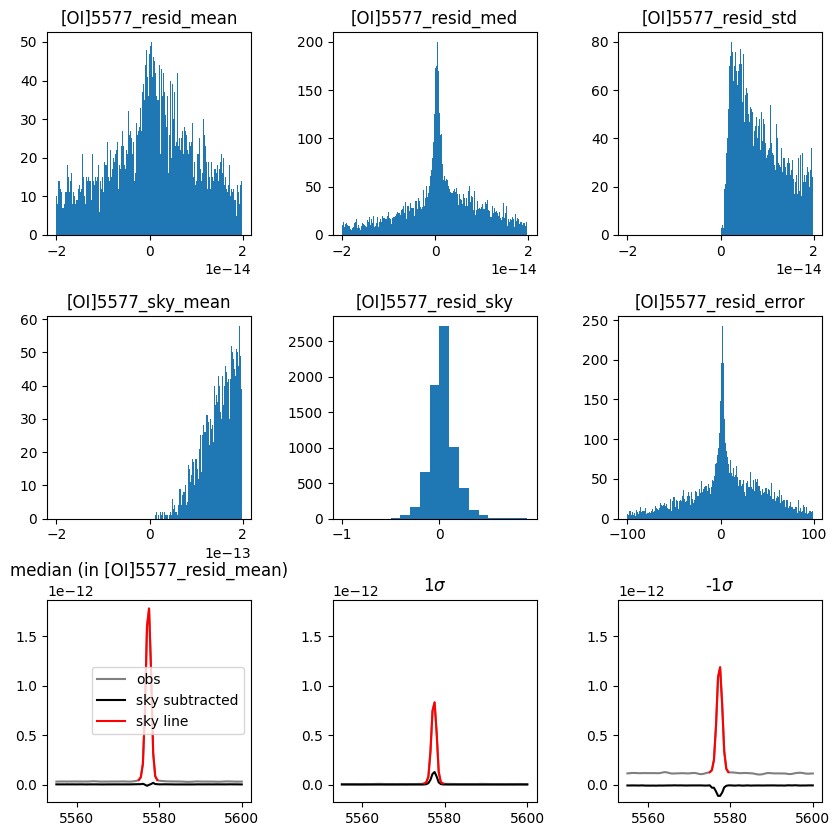

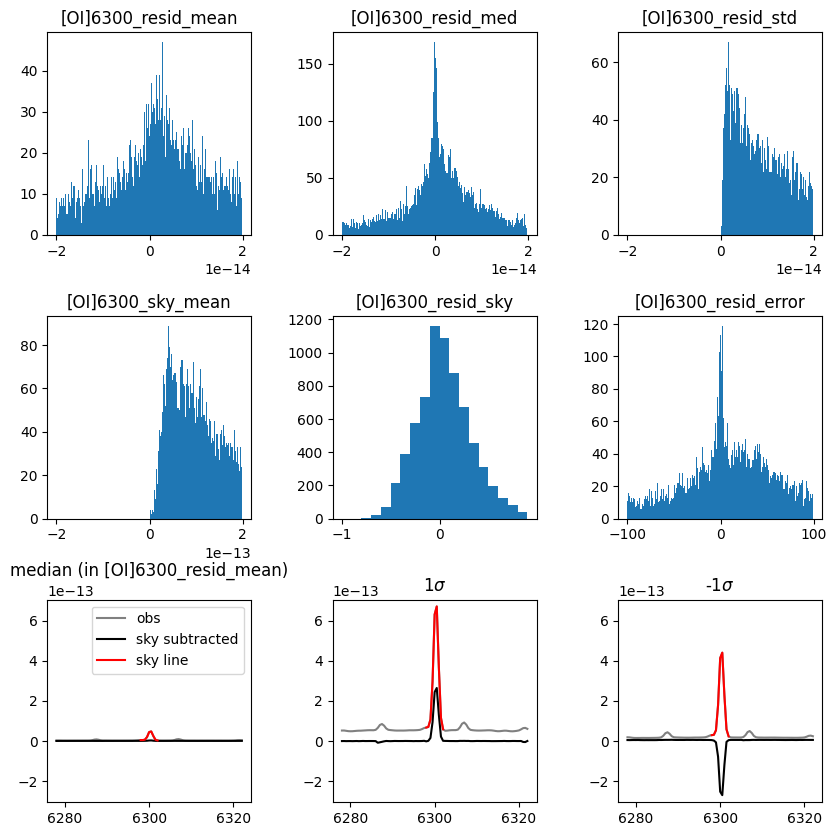

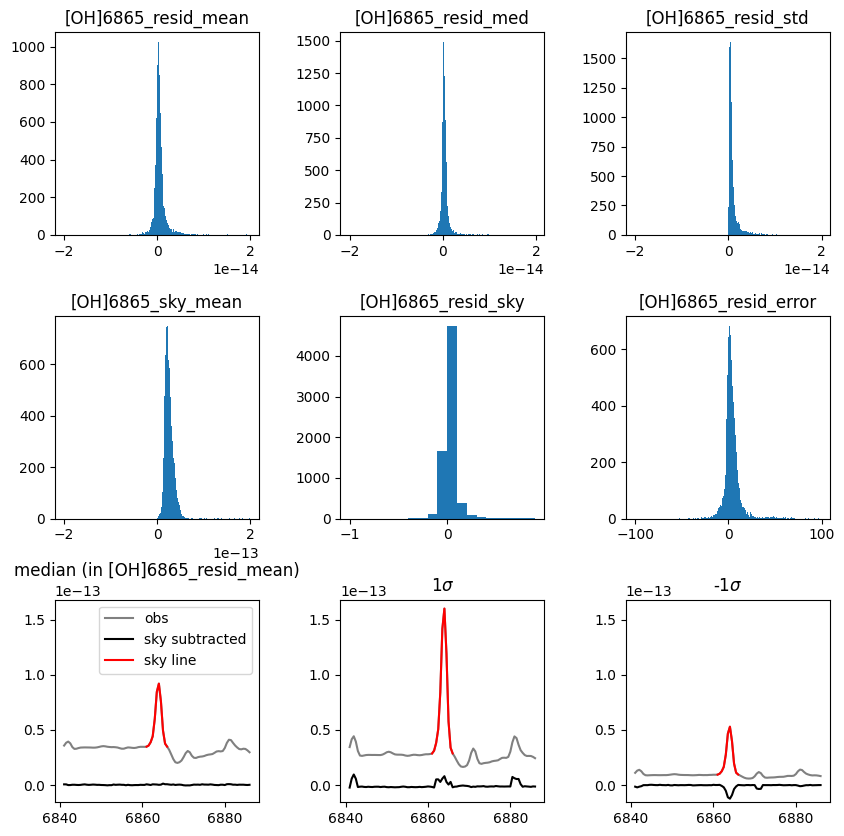

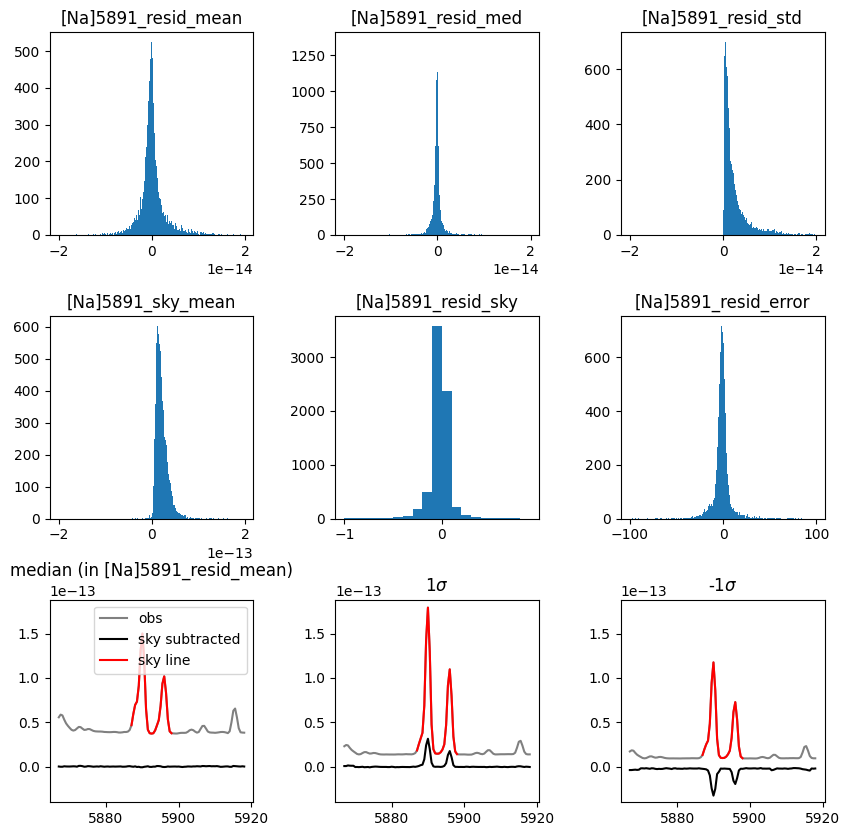

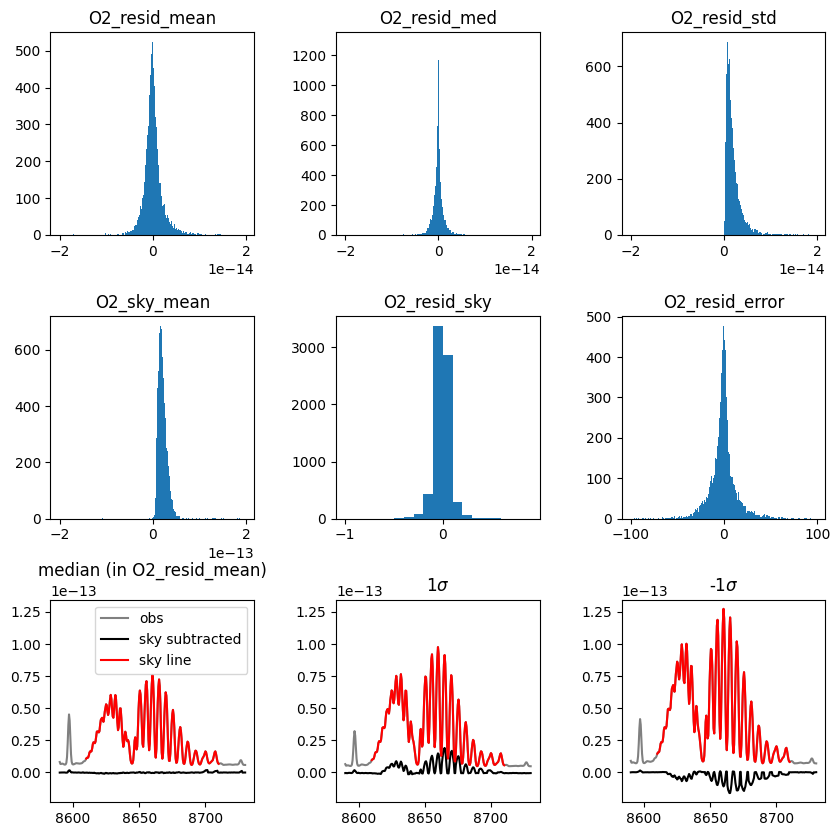

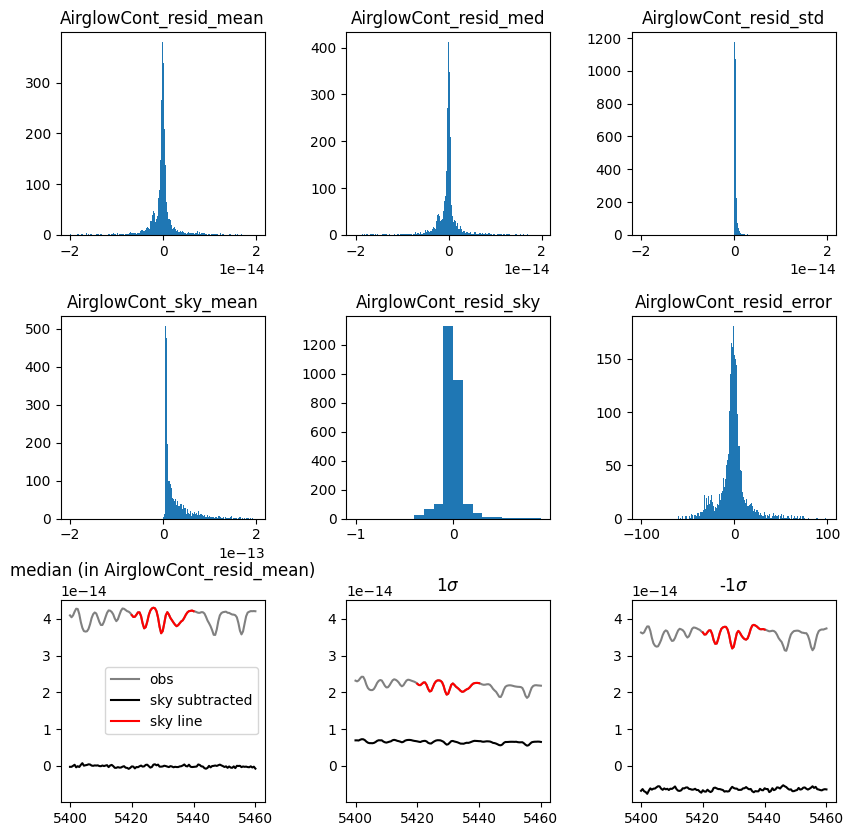

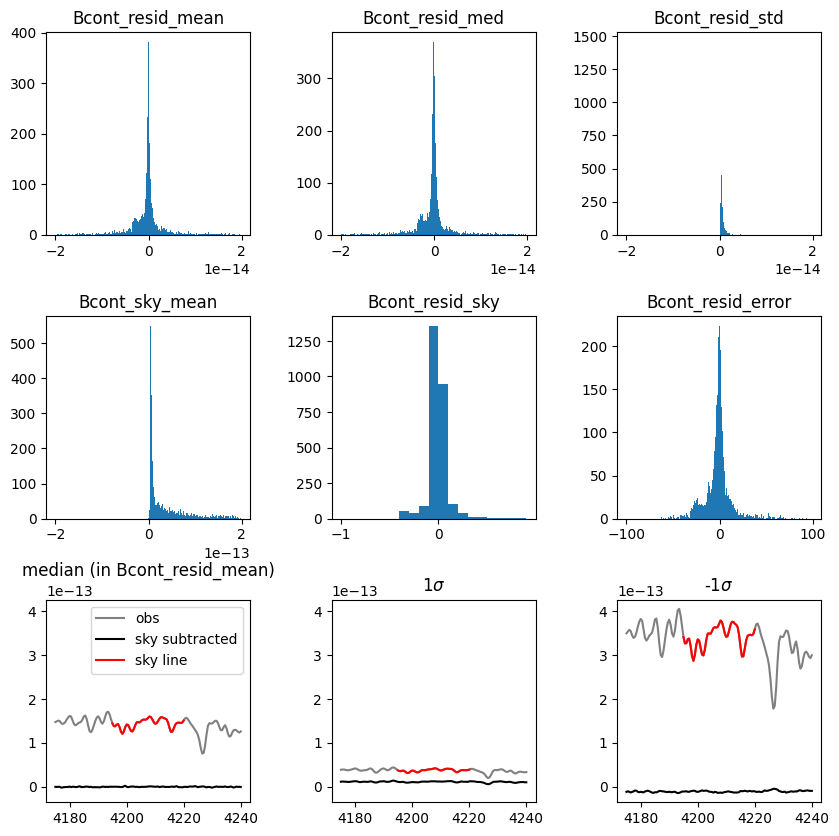

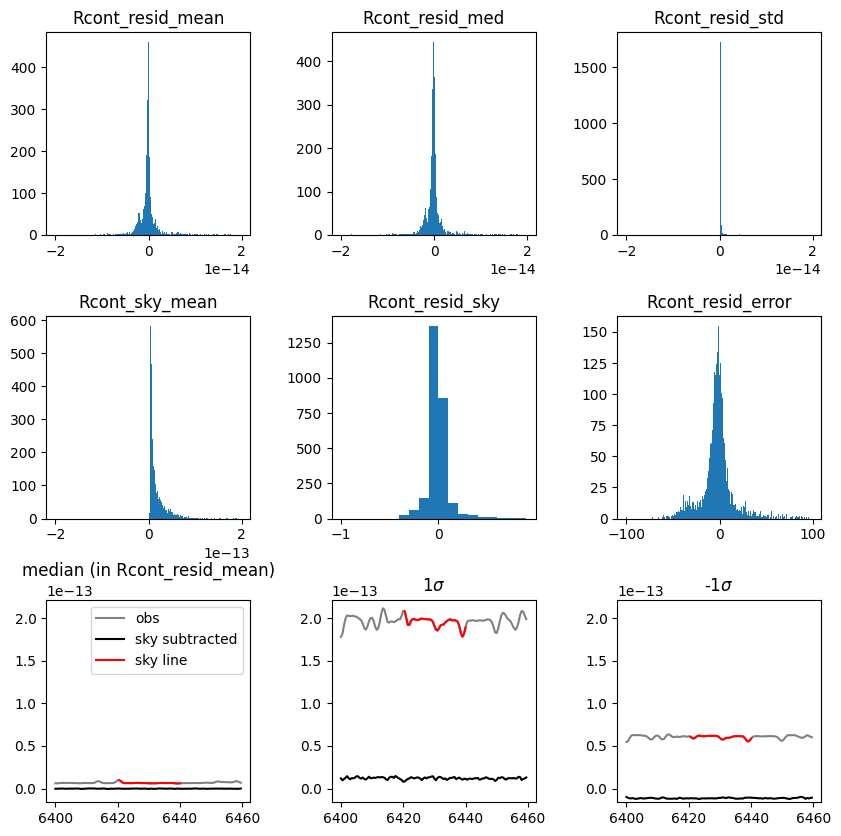

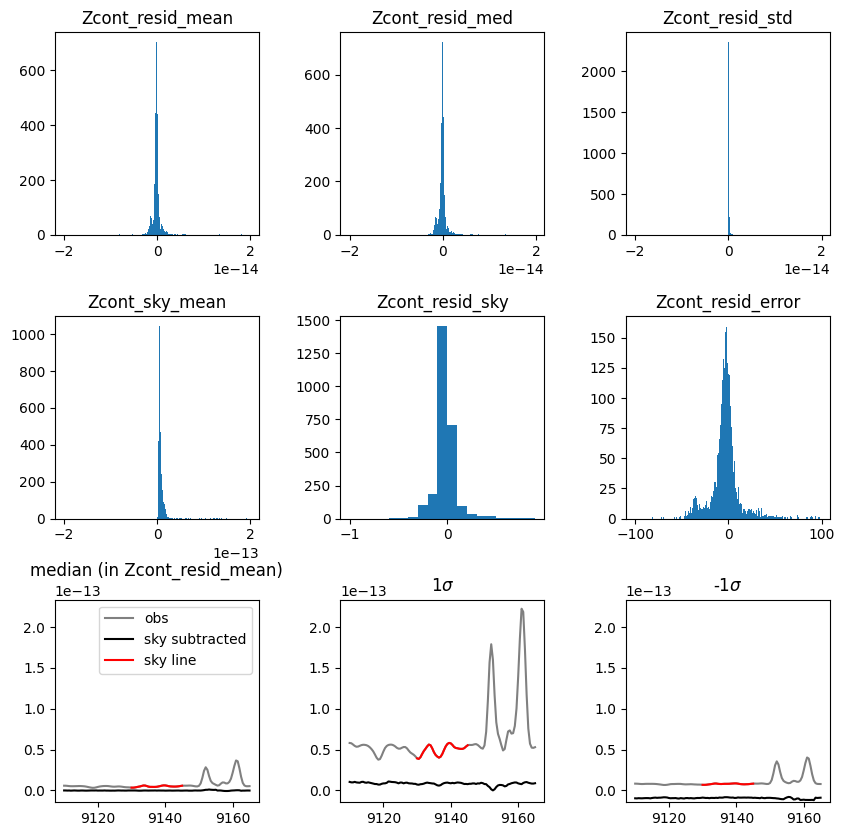

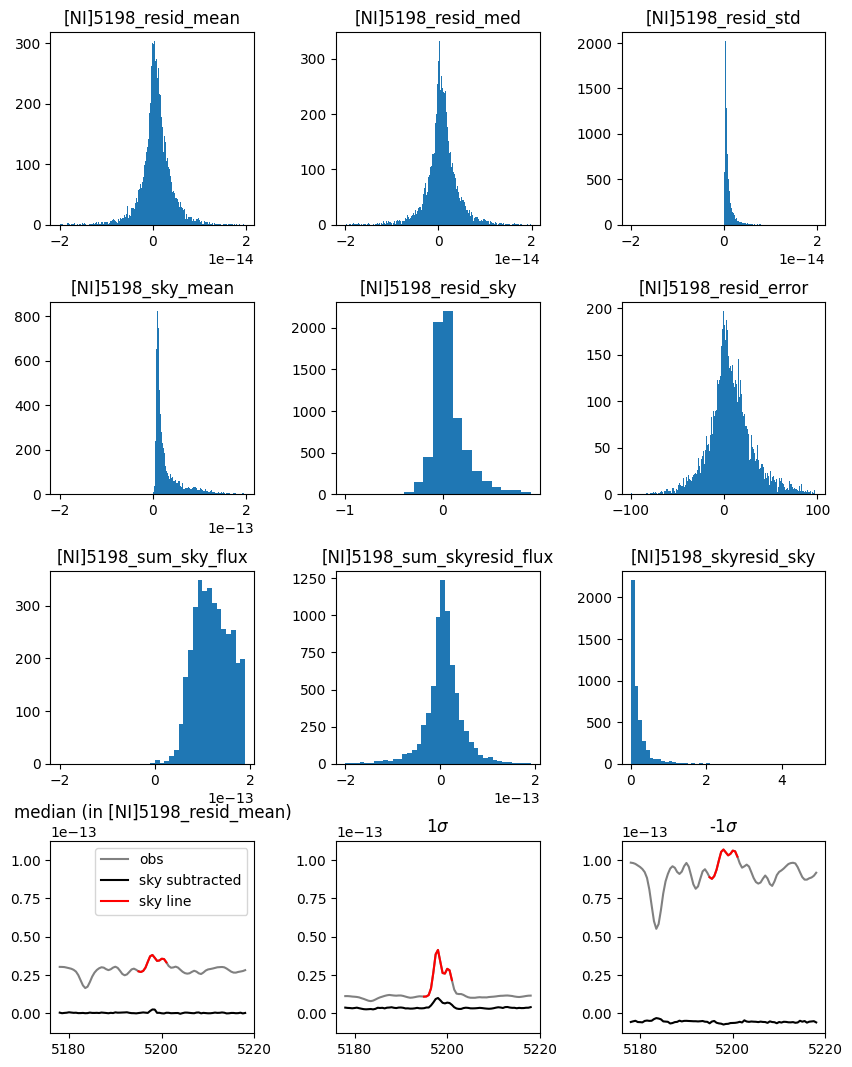

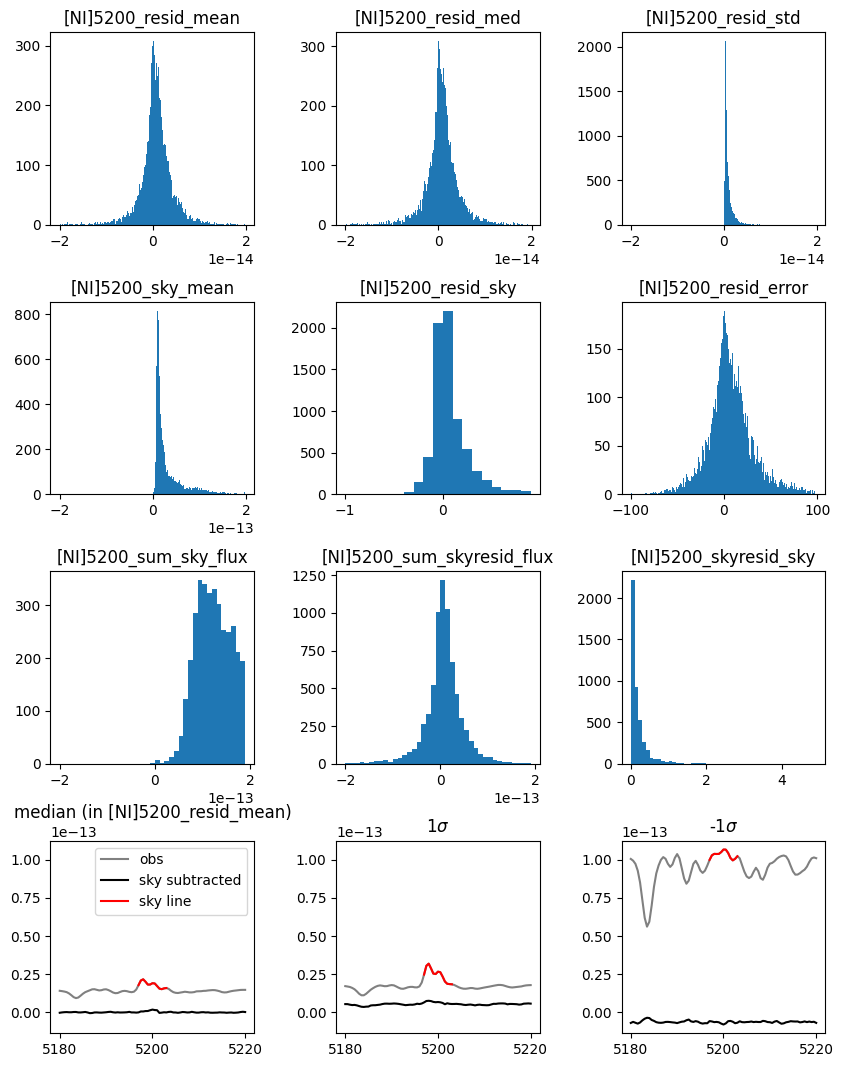

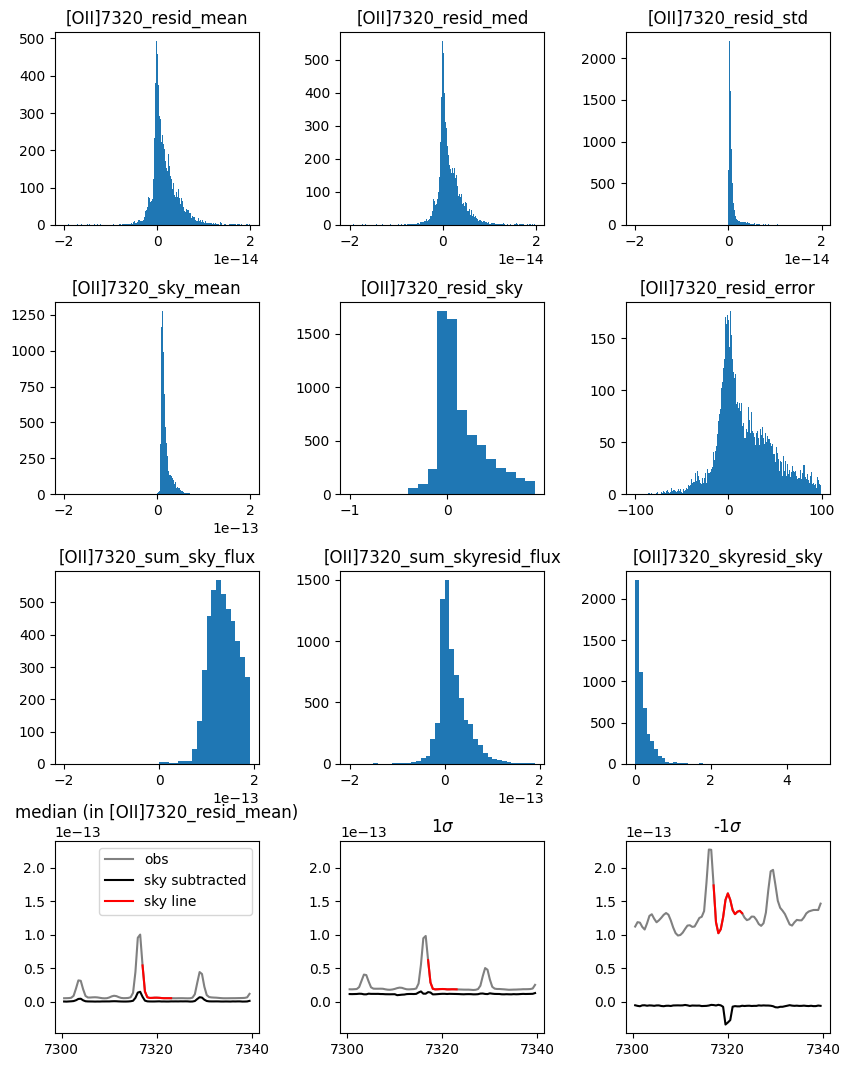

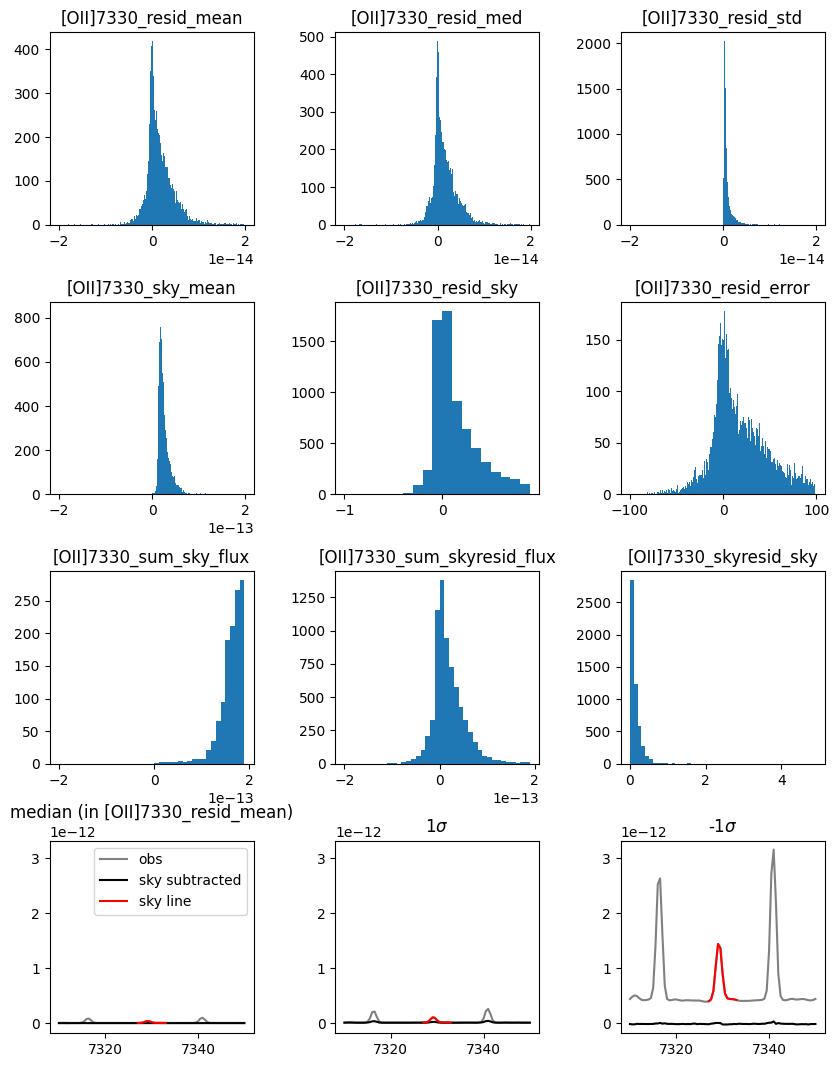

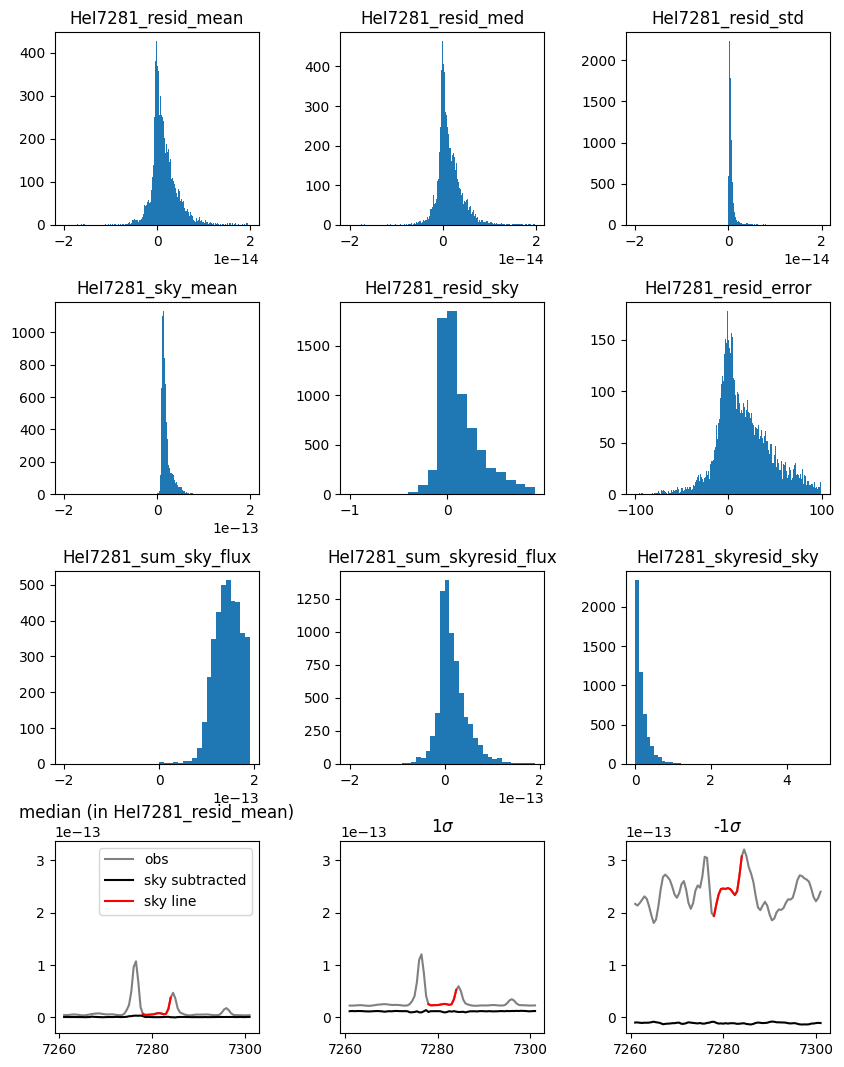

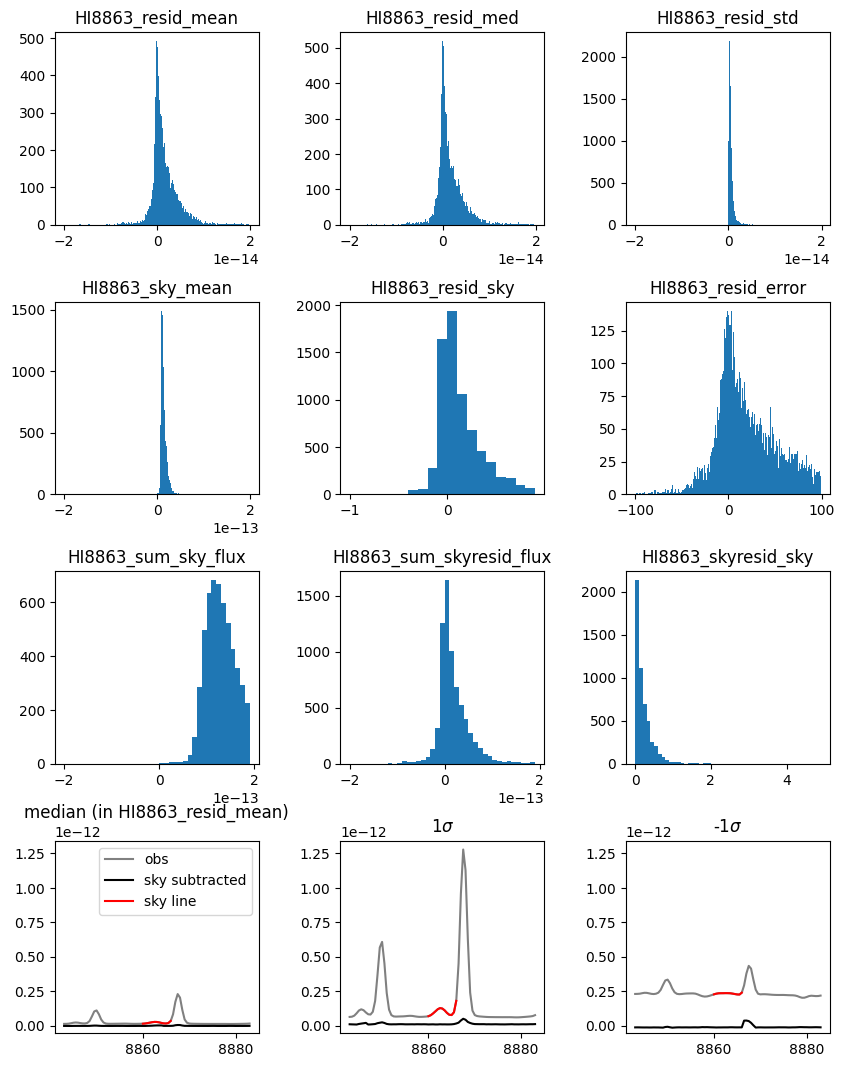

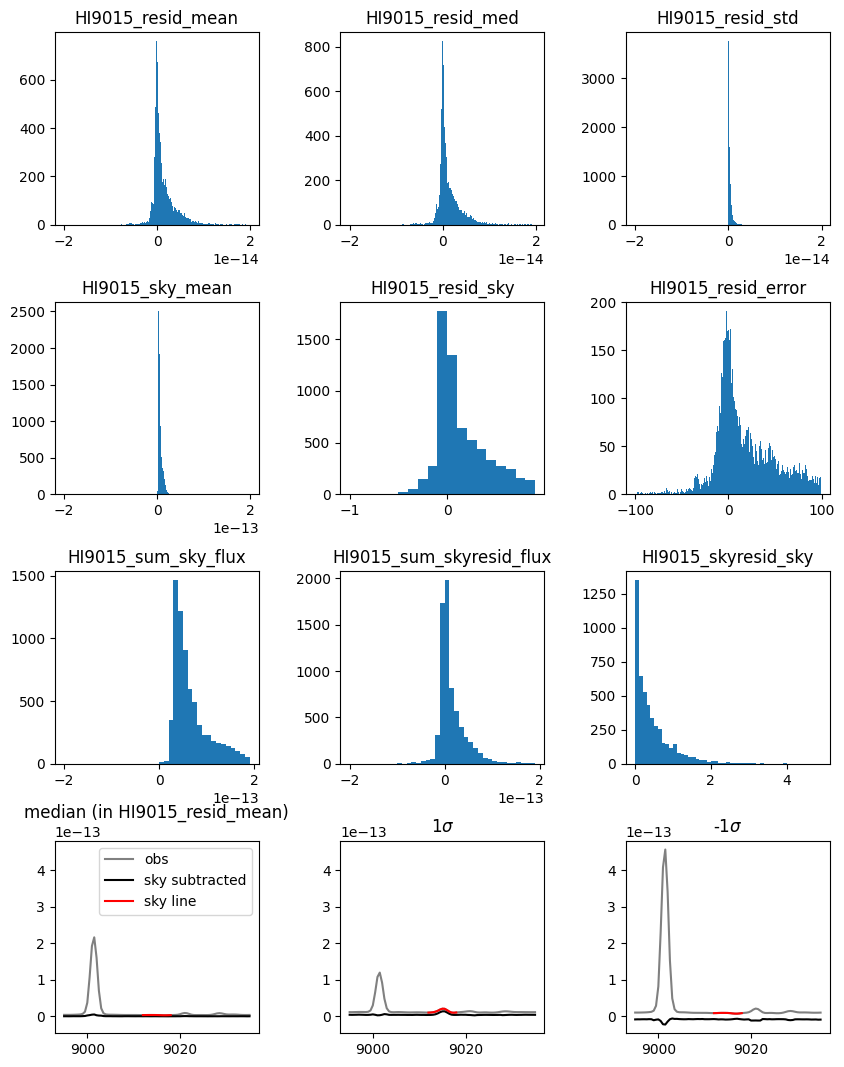

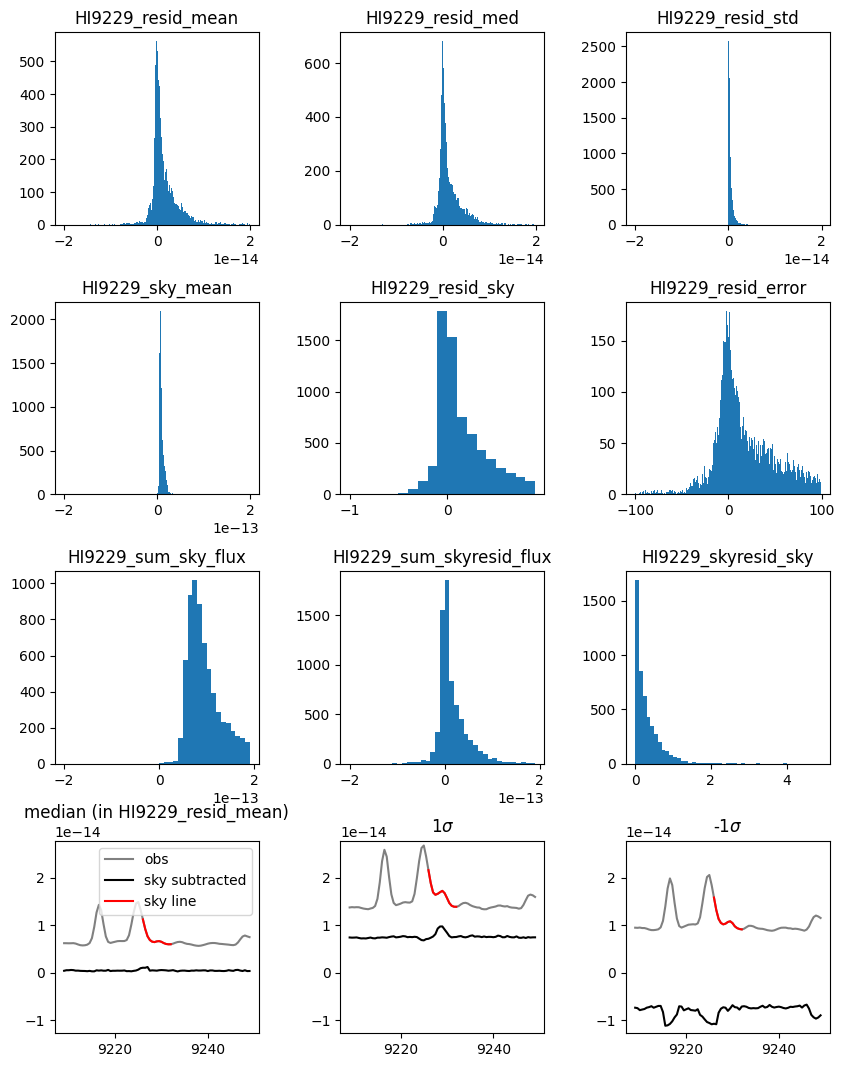

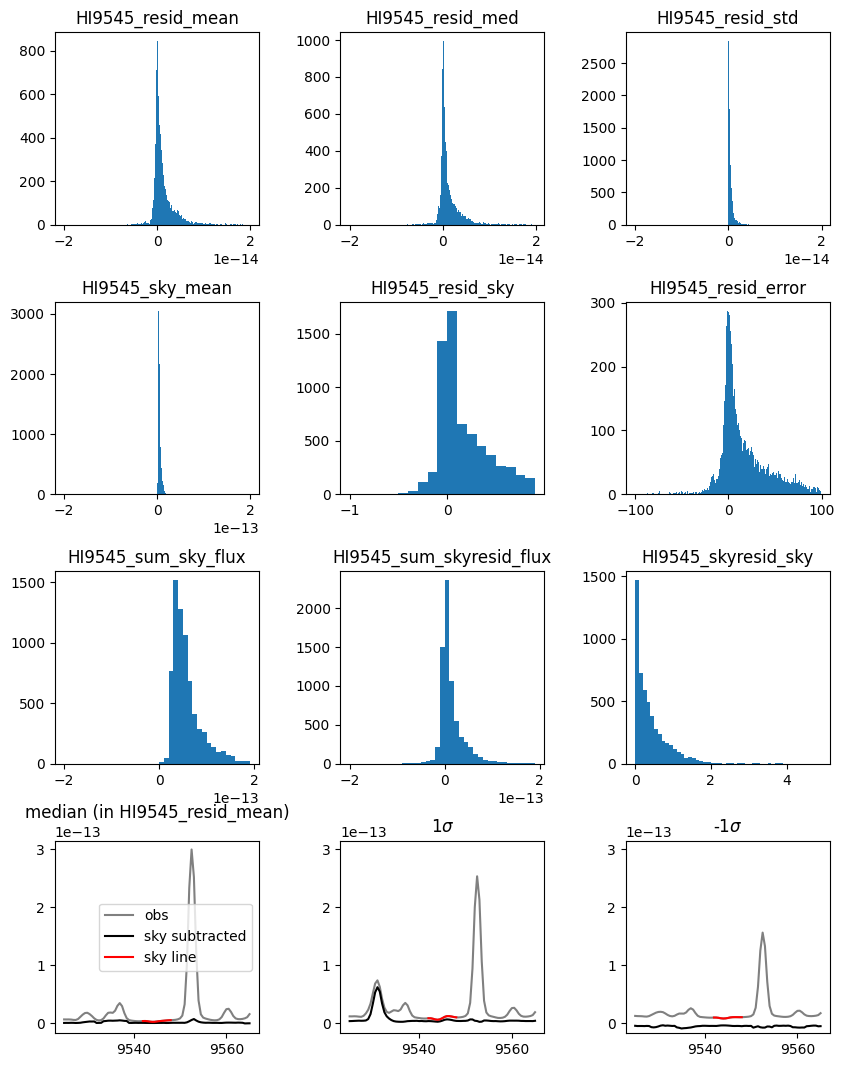

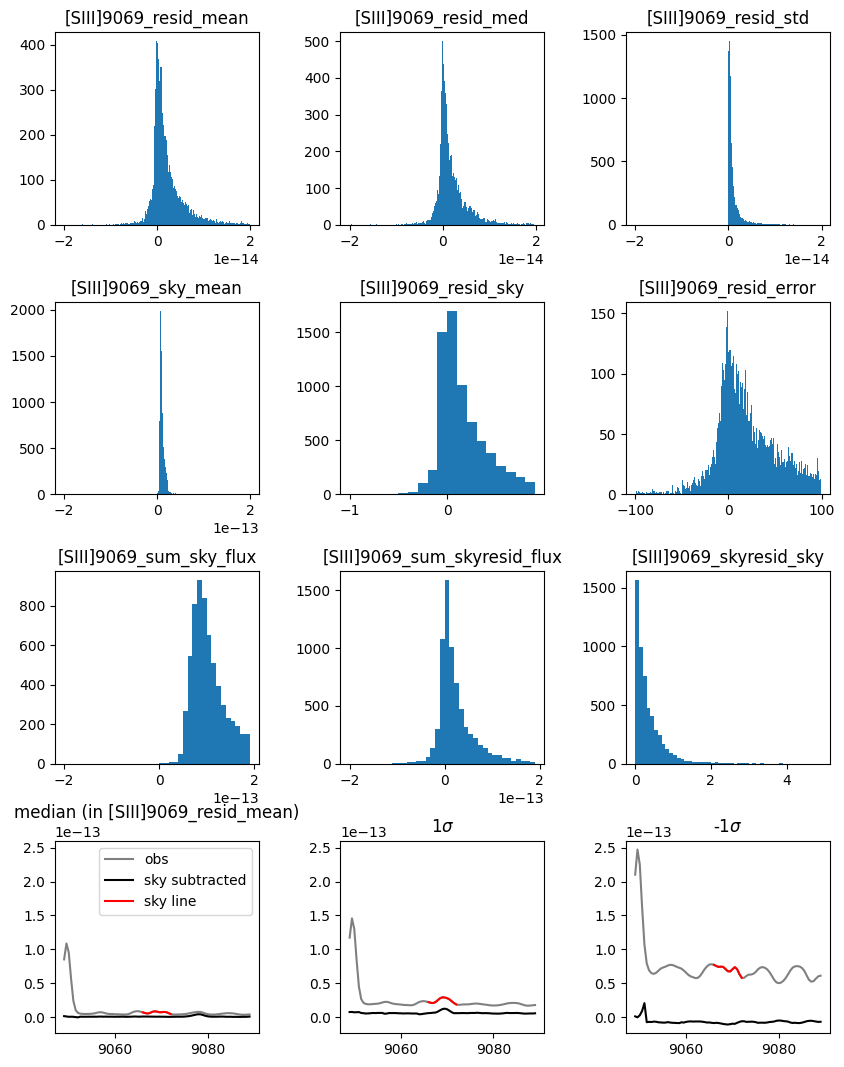

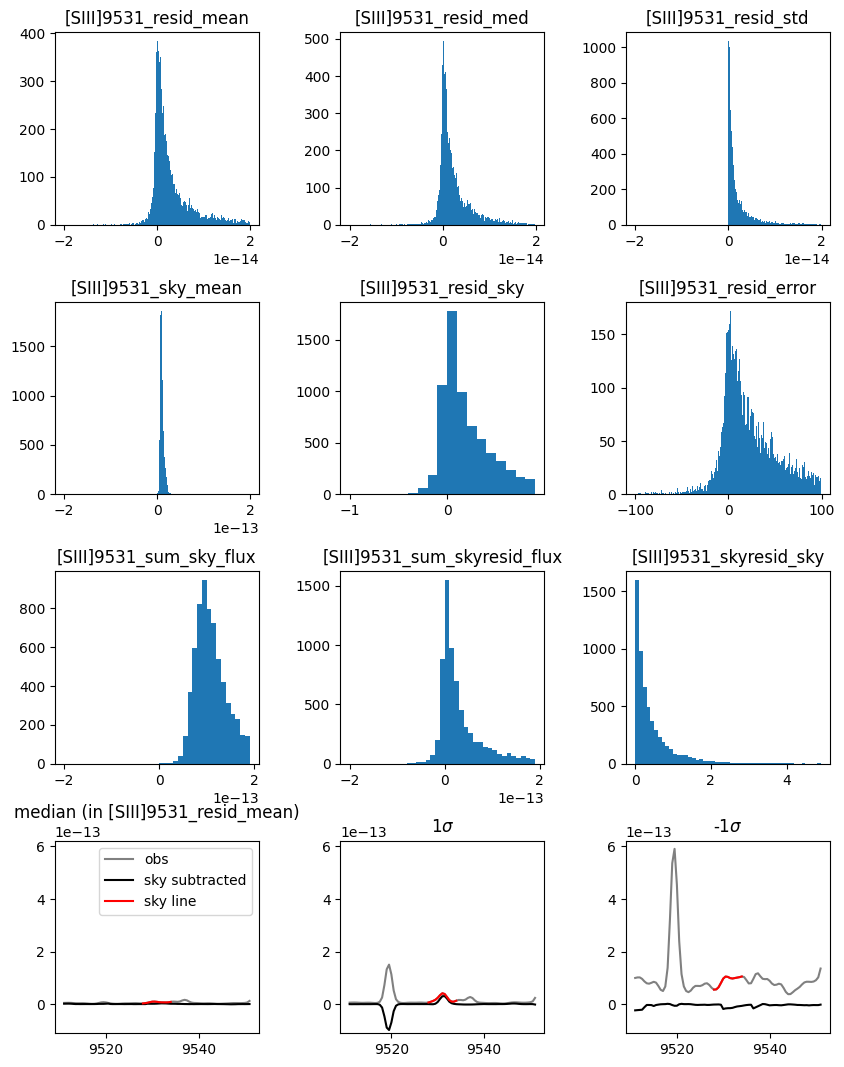

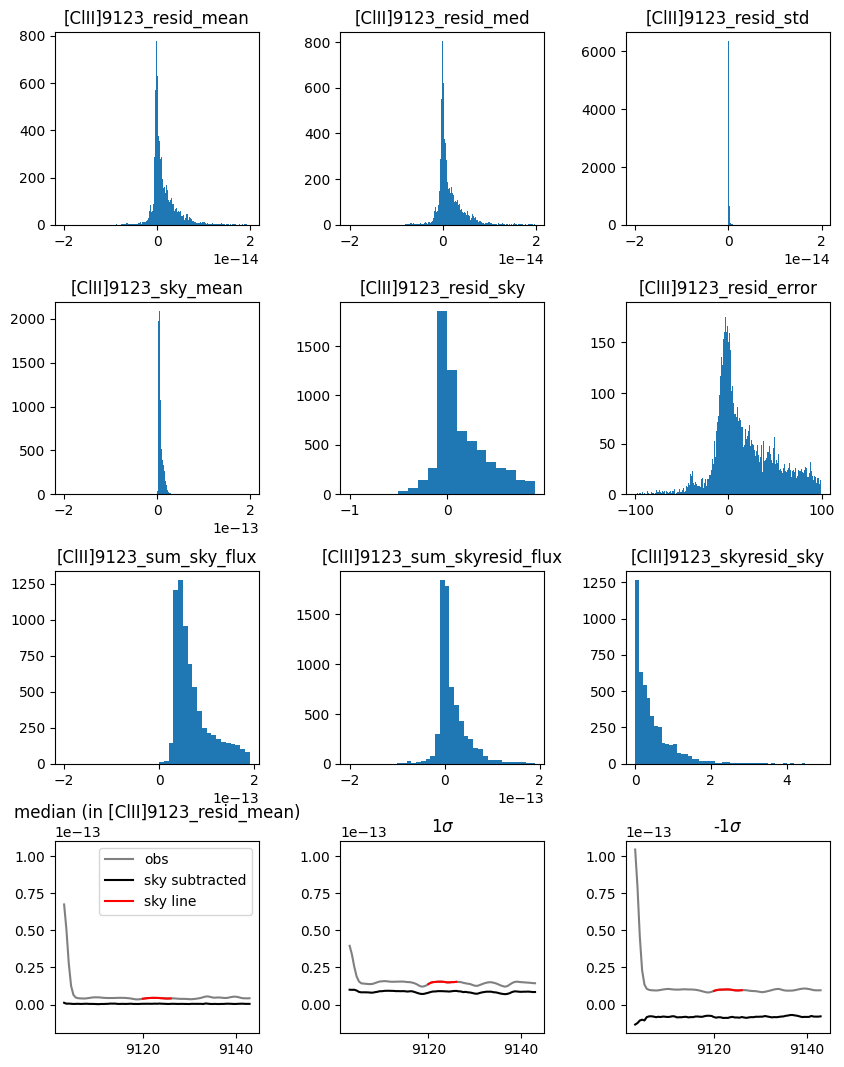

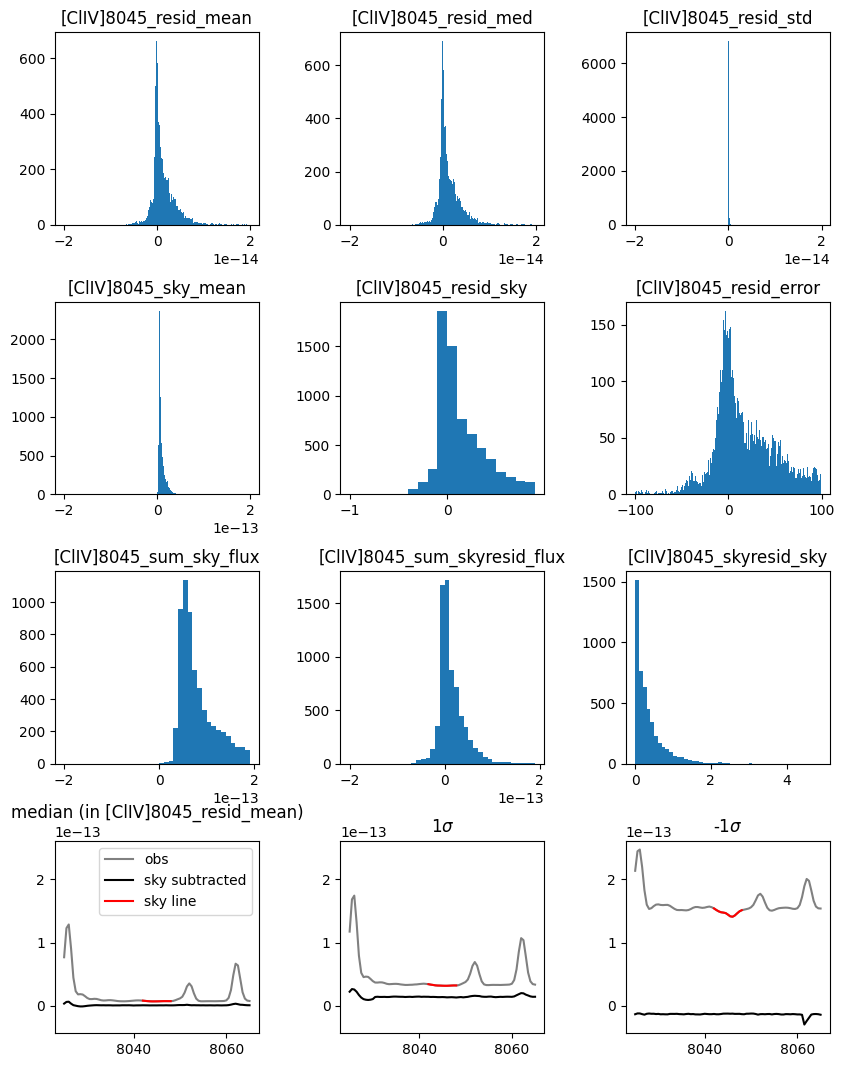

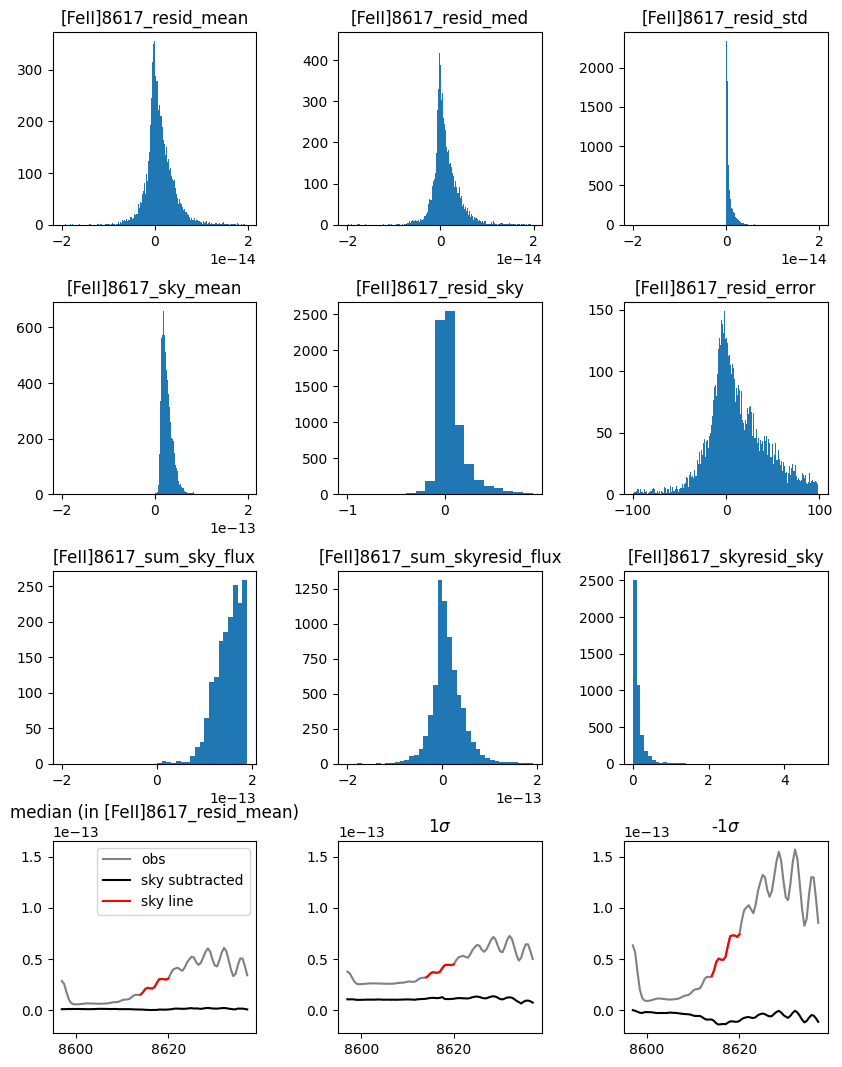

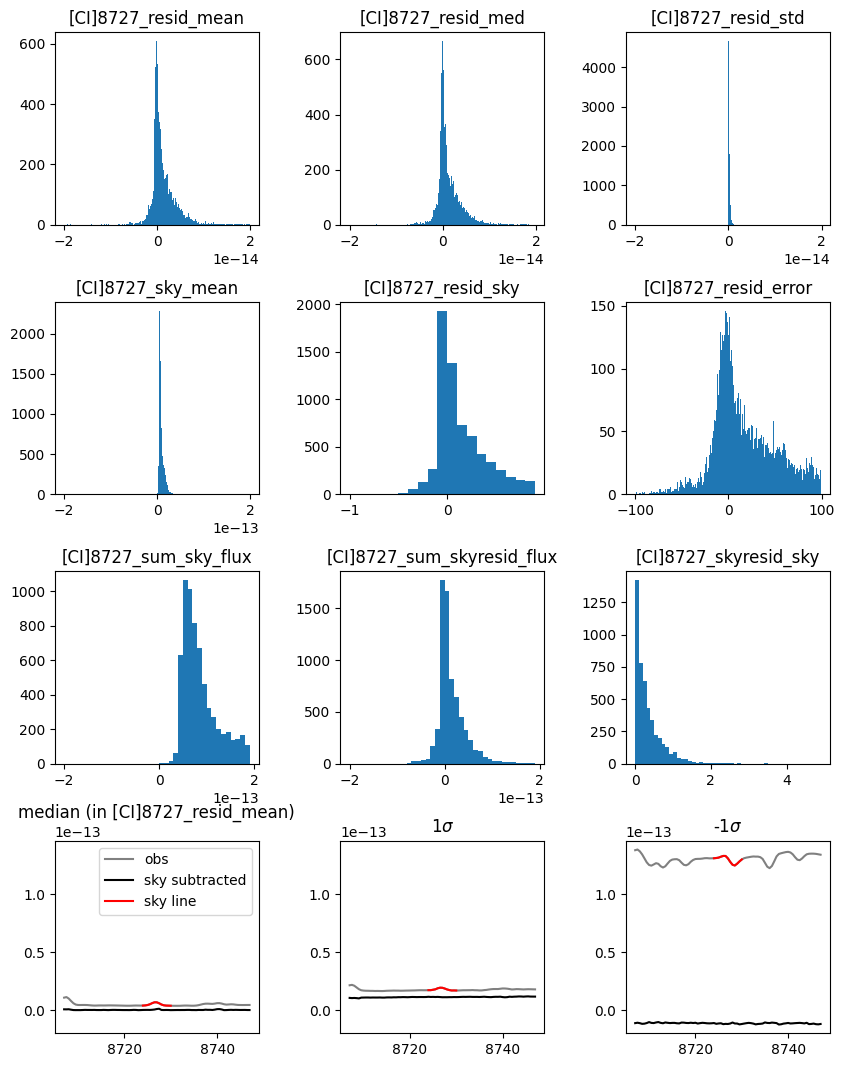

In [250]:
# loop over all the lines and make plots

sci_tiles = (drpall['tileid'] != 11111) & (np.abs(np.nanmax(flux,axis=1)) < 1e-12)
# exclude the early science/non survey frames
# exclude things where the flux calibration failed

all_sky_tiles = sci_tiles & (drpall['Survey'] == 'HighLat')
# exclude the early science/non survey frames
# exclude things where the flux calibration failed
# pick only the High latutide tiles, as they are presumably (mostly) dark in stellar continuum

for i,which_line in enumerate(sky_list):
    # for continuum metrics, use the all sky/high latitutde tiles
    if crangelist[i][0] == -999:
        make_plot(which_line, tab,wave,flux,sky,all_sky_tiles,out_dir)
    # otherwise use all the survey tiles
    else:
        make_plot(which_line, tab,wave,flux,sky,sci_tiles,out_dir)

for which_line in sci_lines:
    make_plot(which_line, tab,wave,flux,sky,sci_tiles, out_dir,flag_sci=True)
    

/var/folders/3f/jd4g1rjd4hbgknq2l_3x82yr0000gp/T/ipykernel_1997/2894162720.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 13),gridspec_kw={'wspace': 0.4, 'hspace': 0.4})


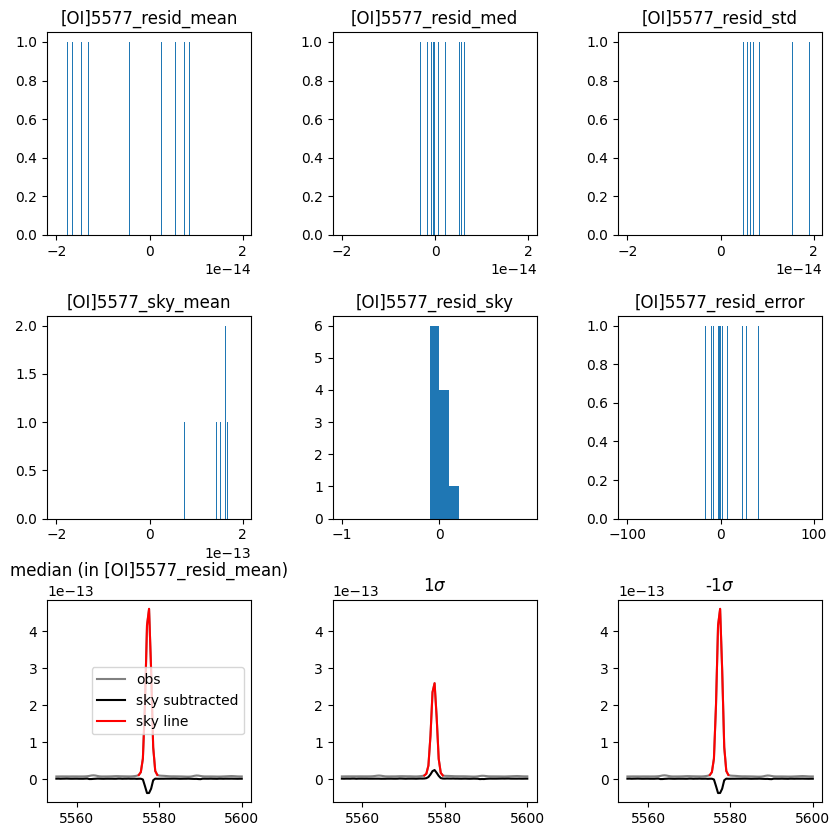

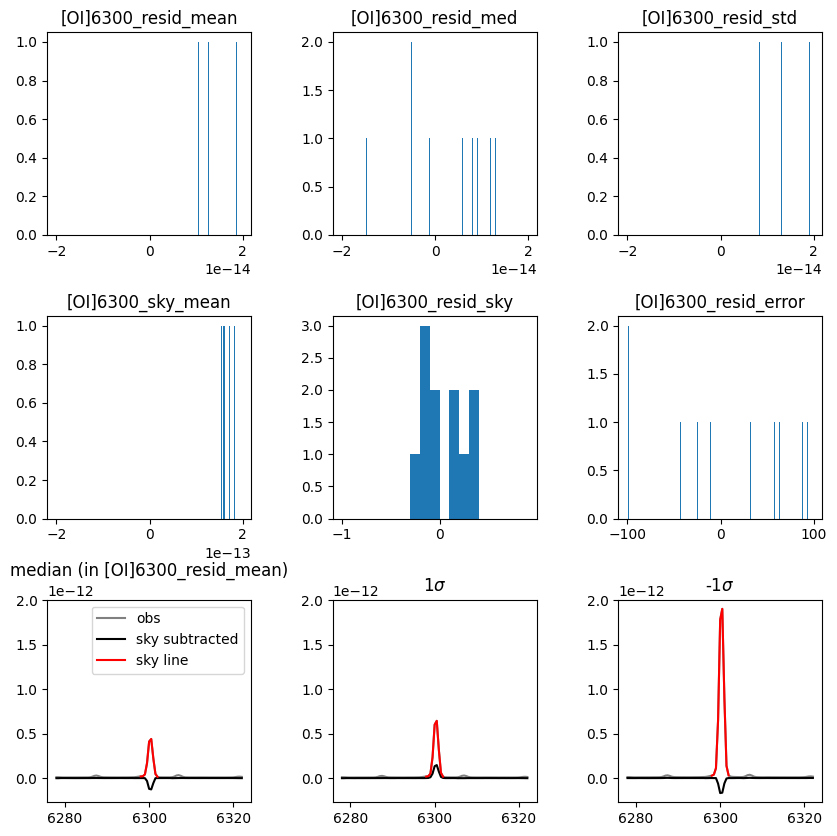

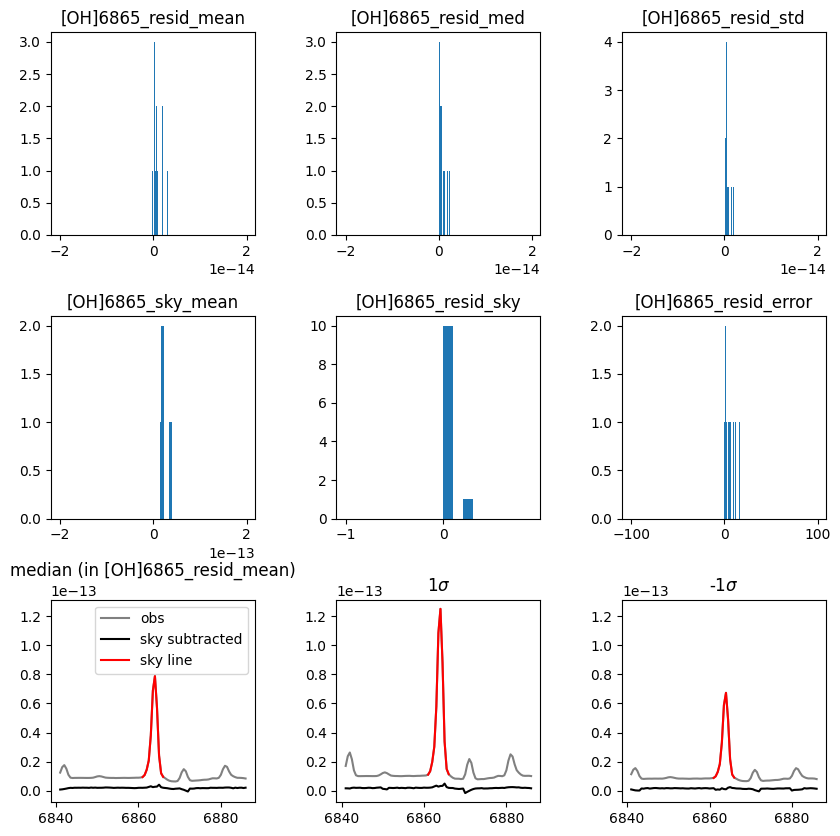

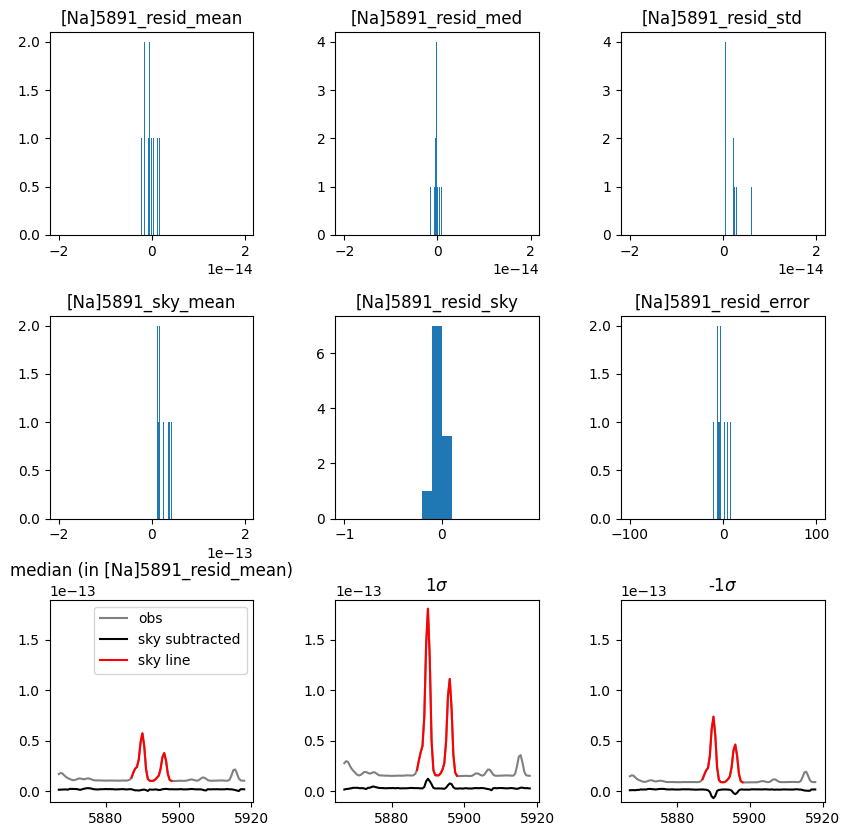

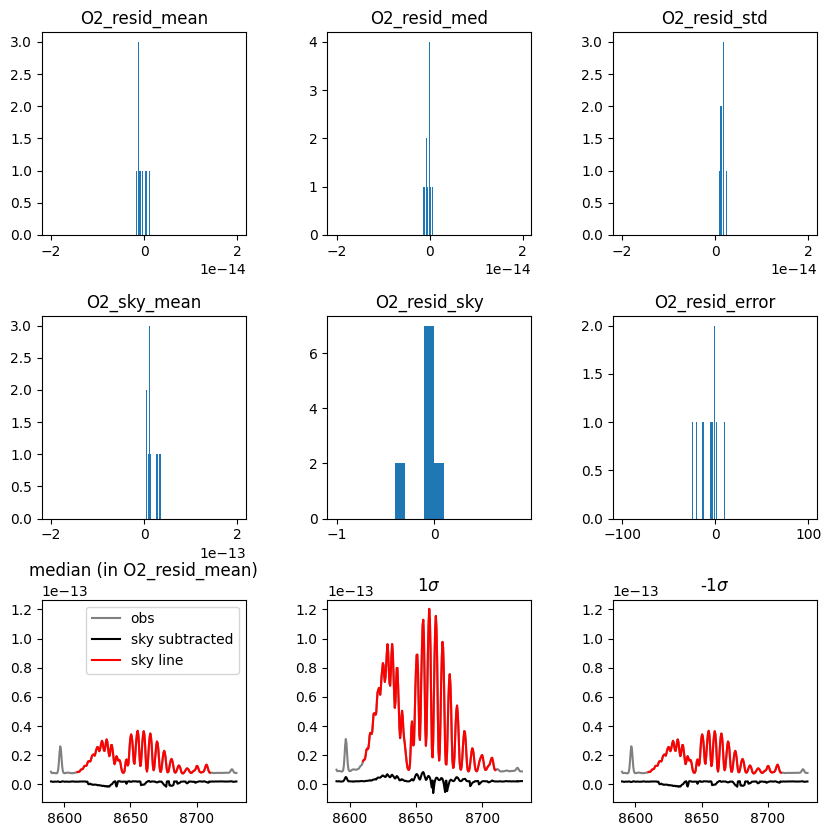

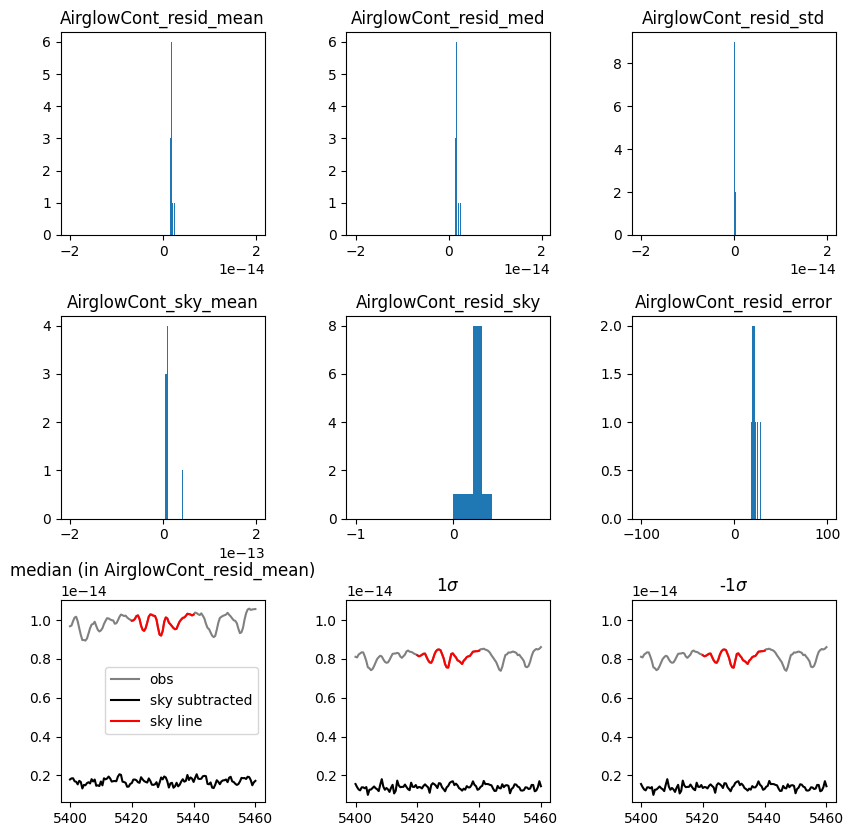

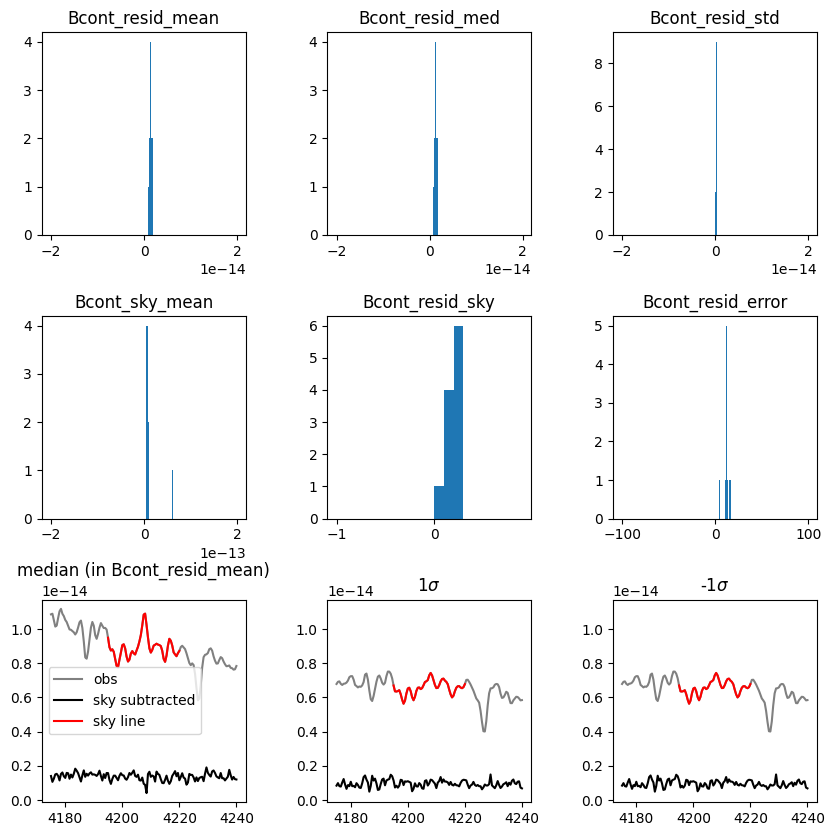

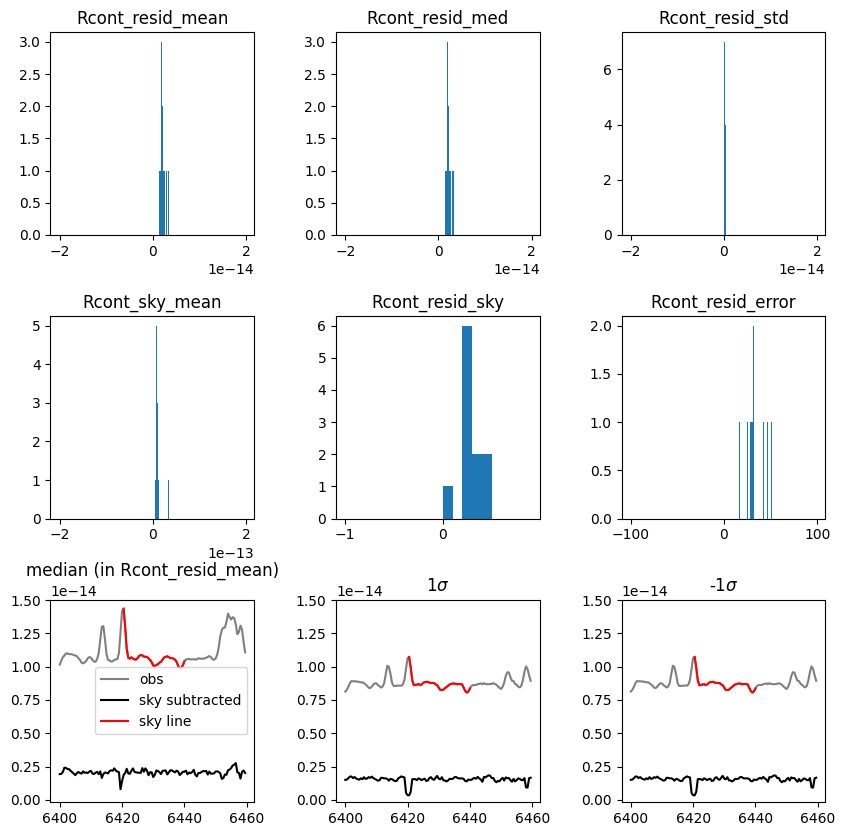

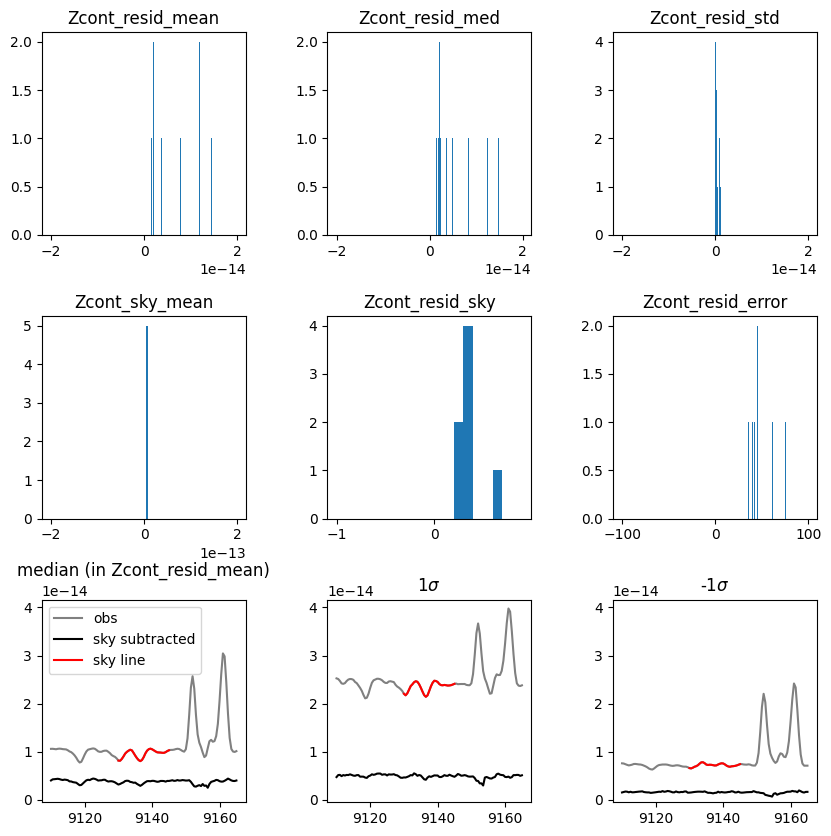

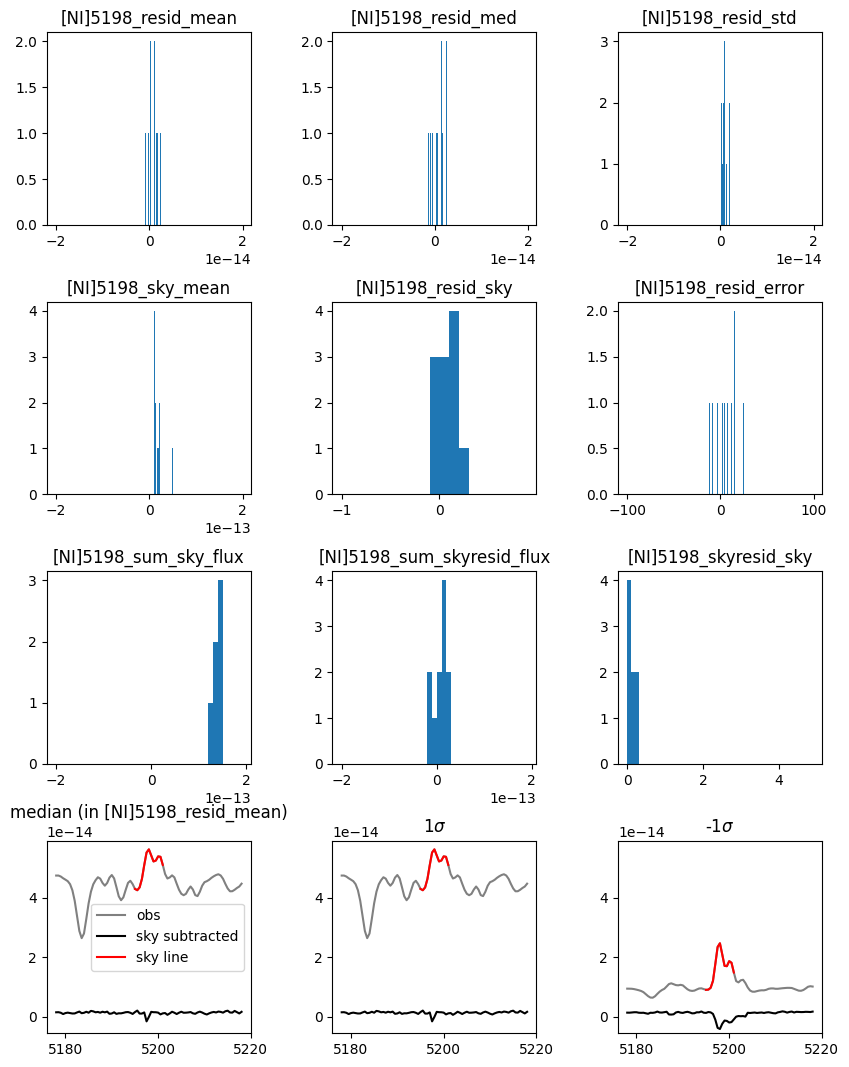

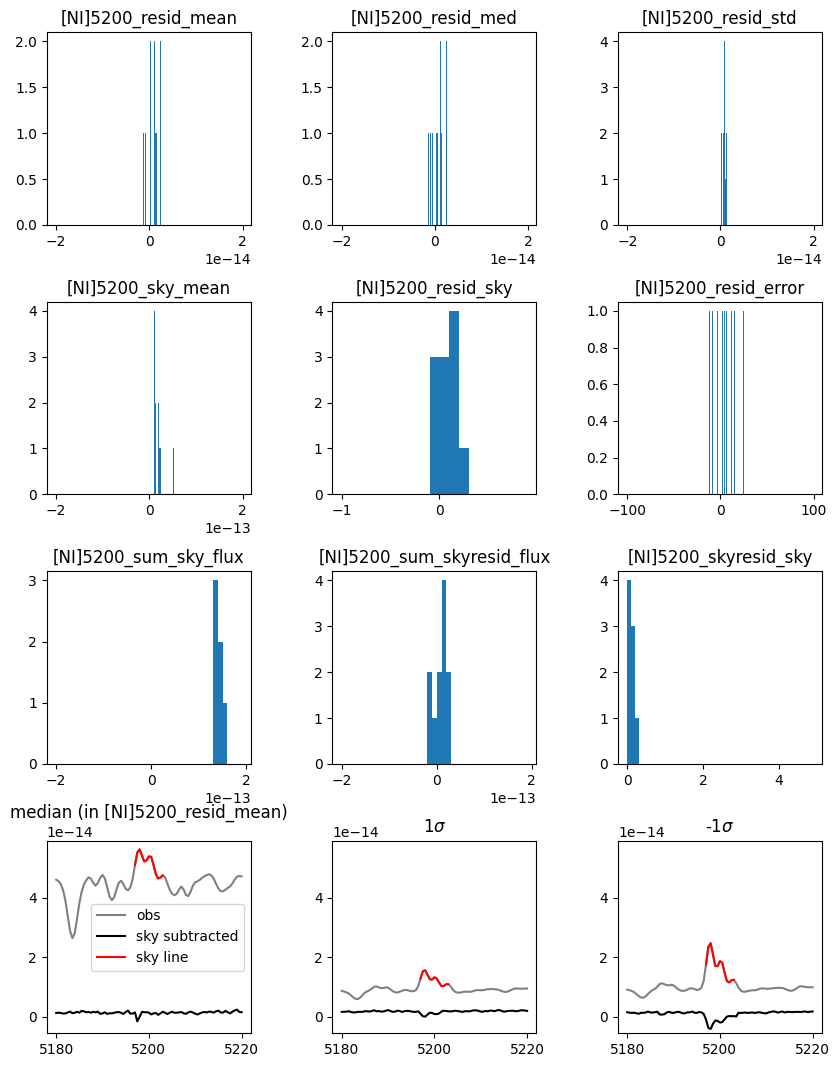

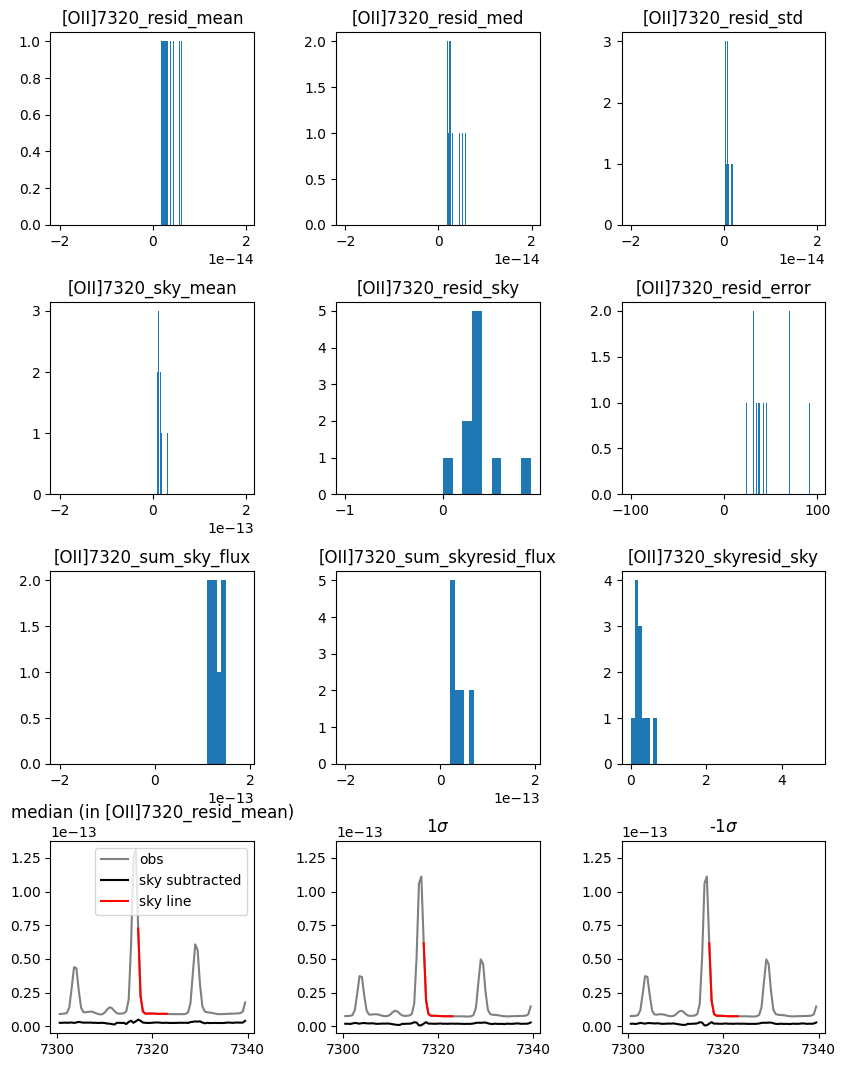

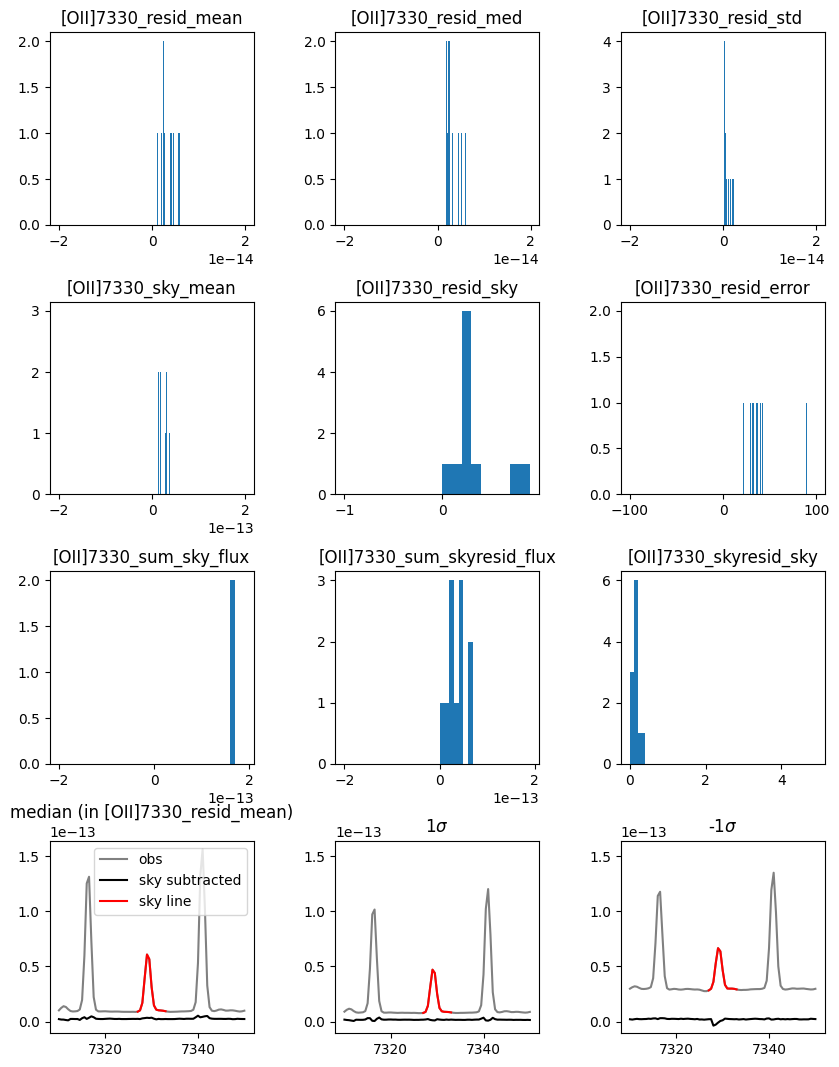

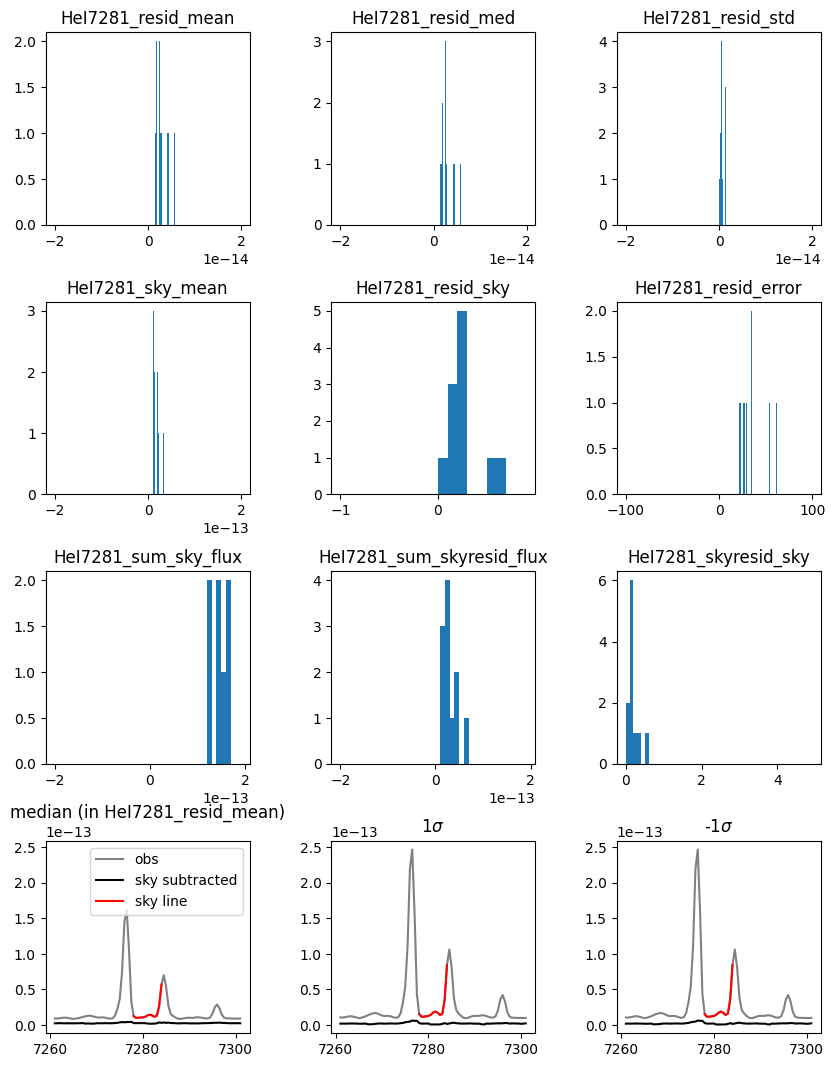

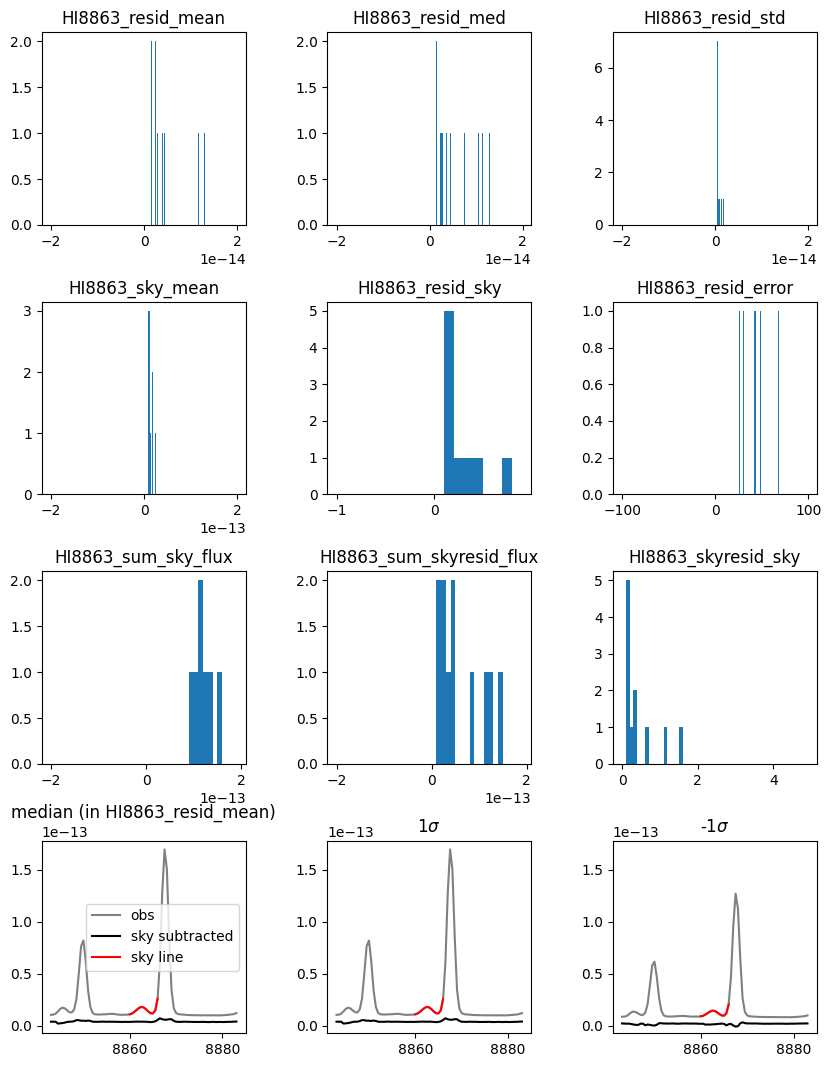

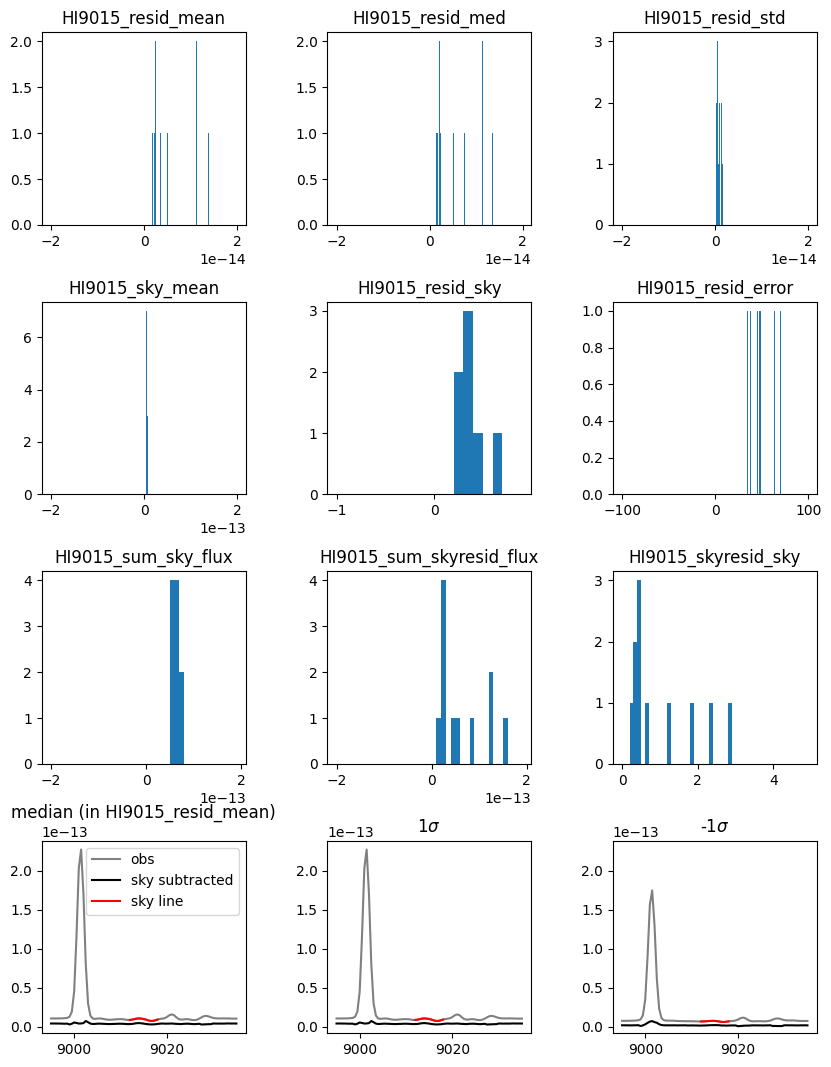

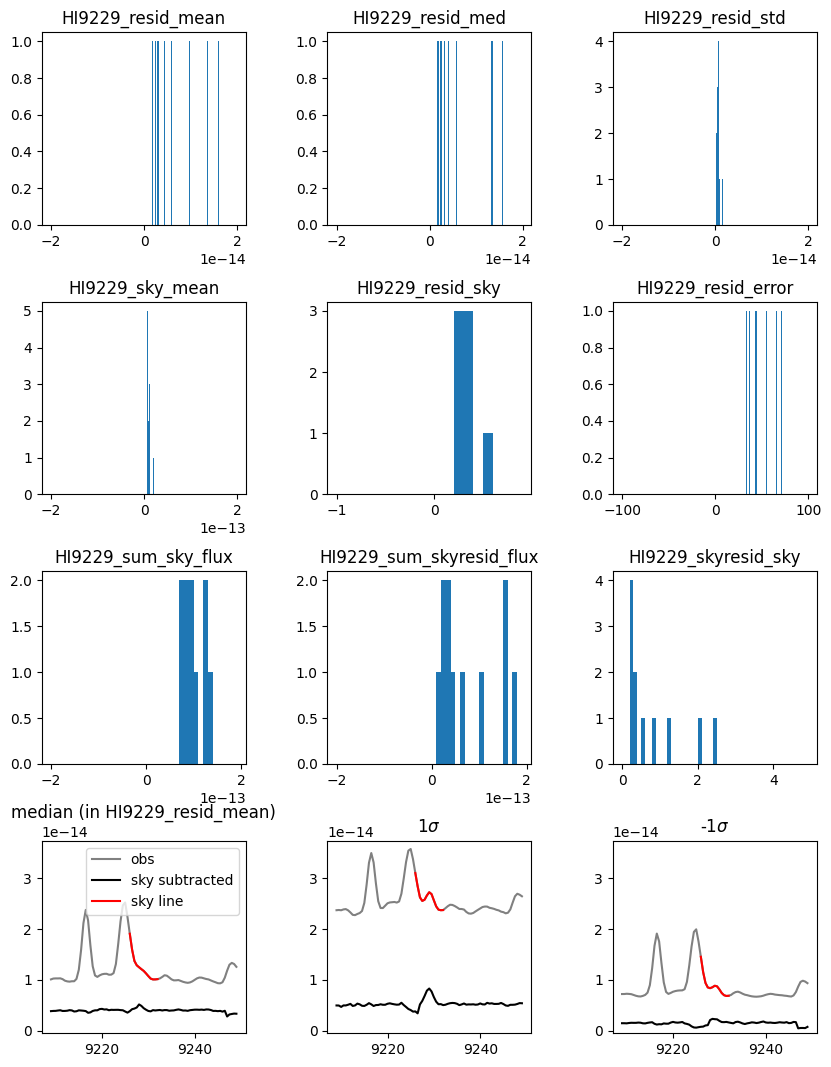

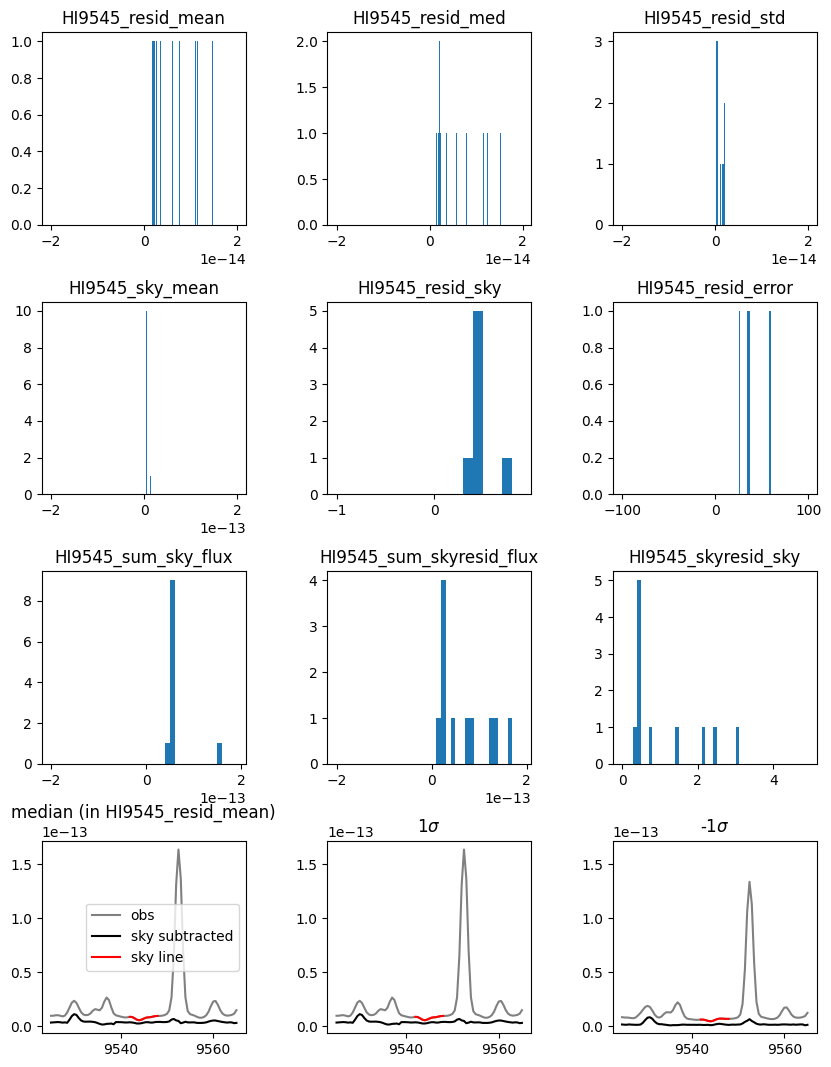

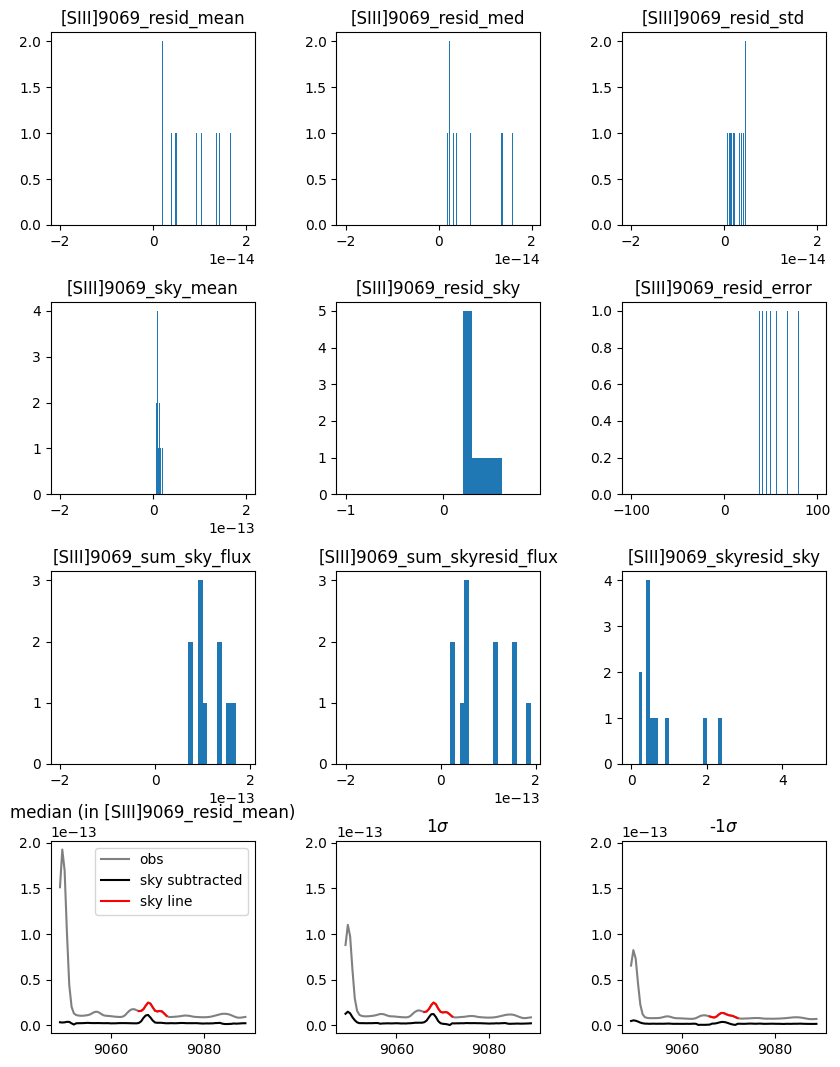

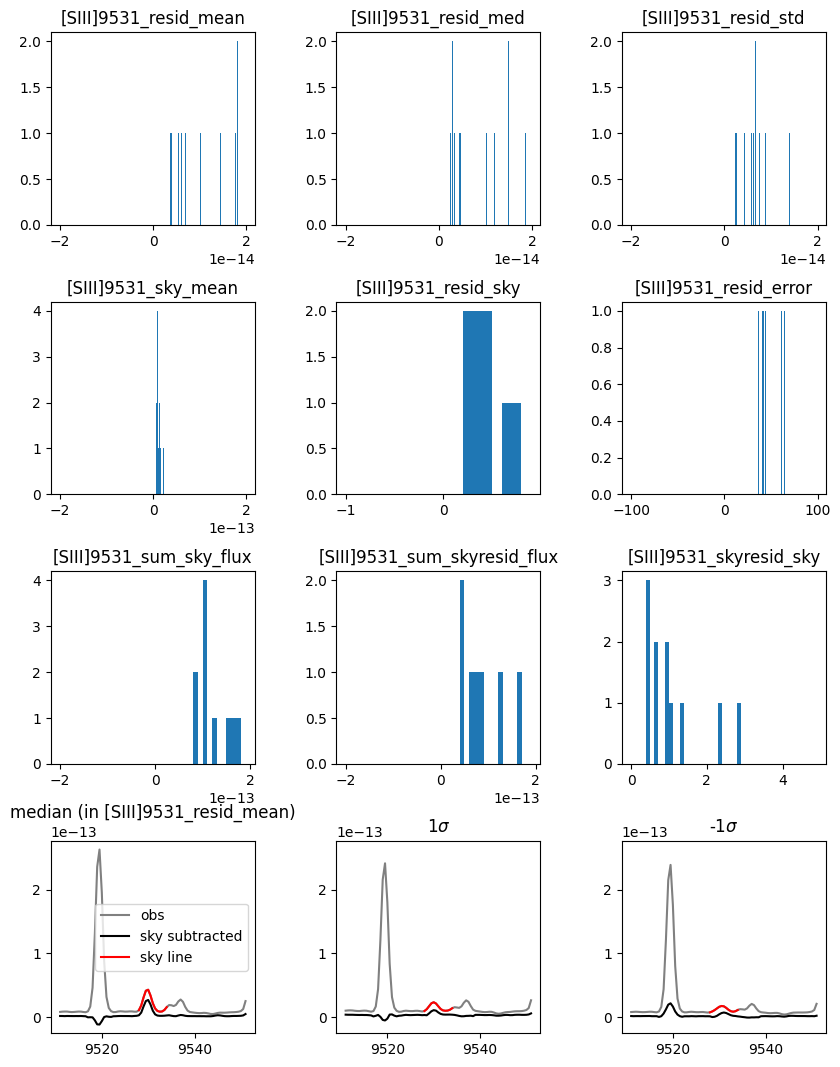

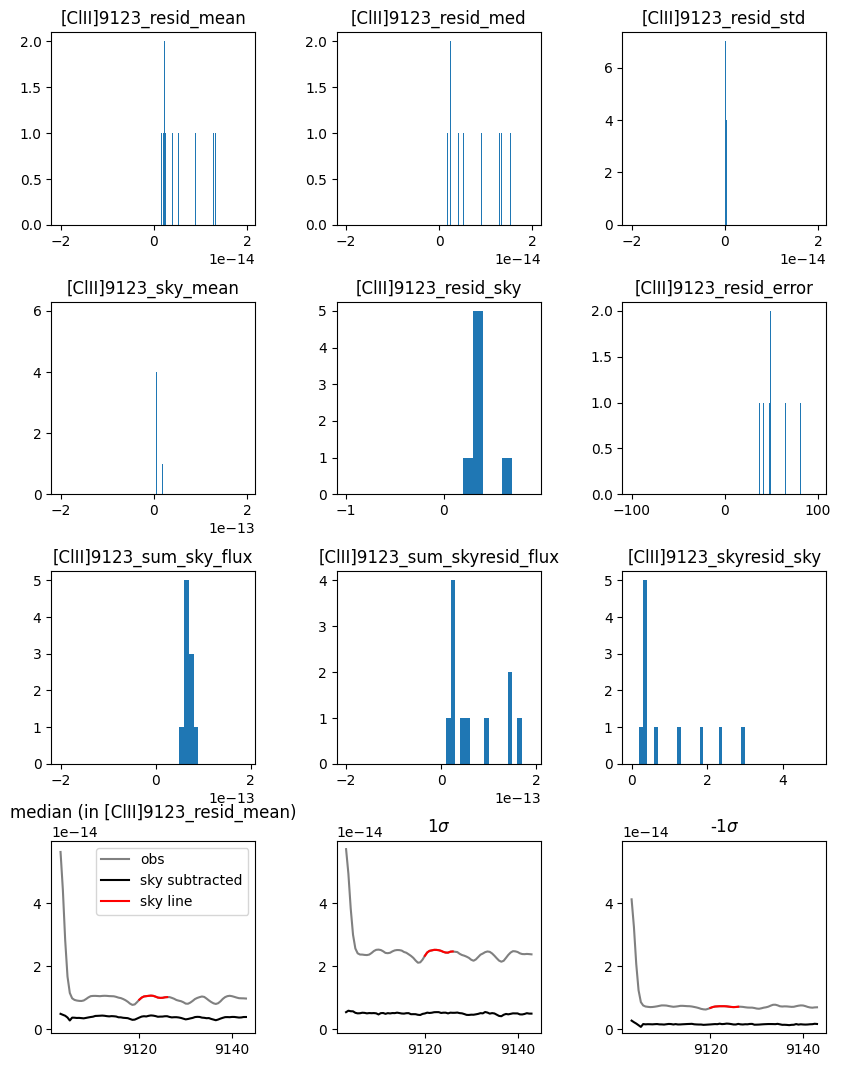

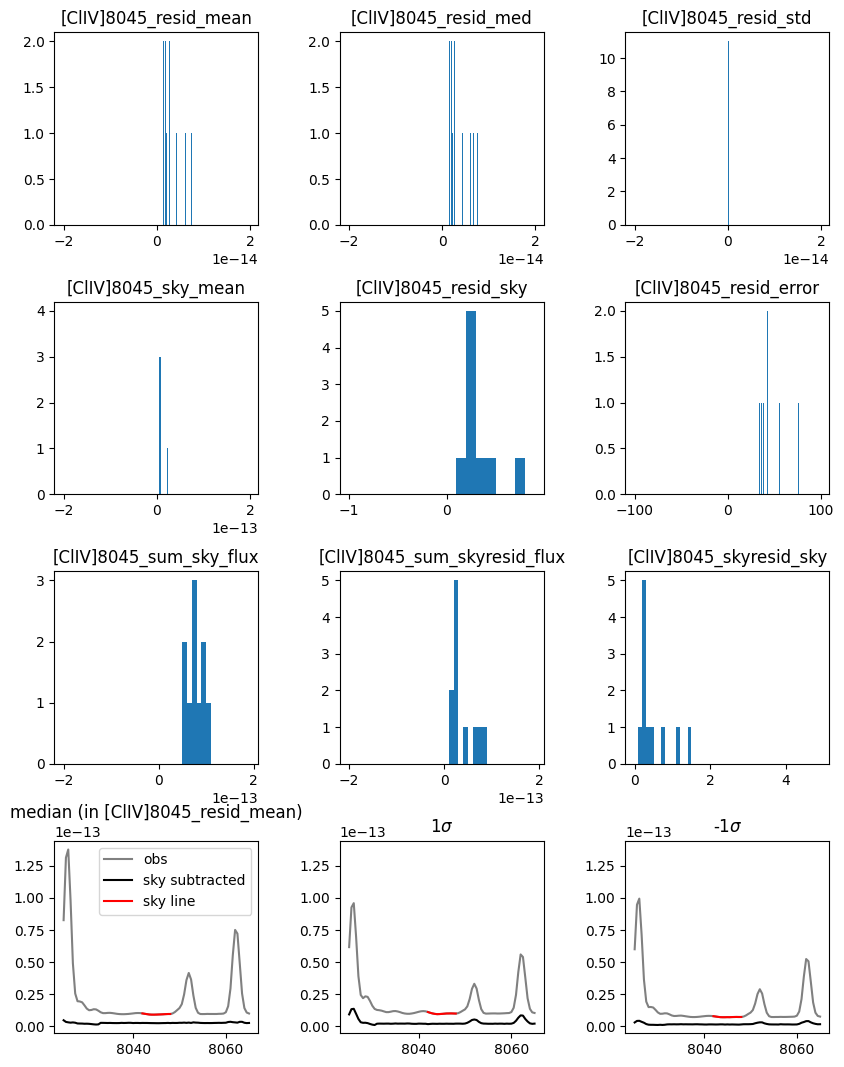

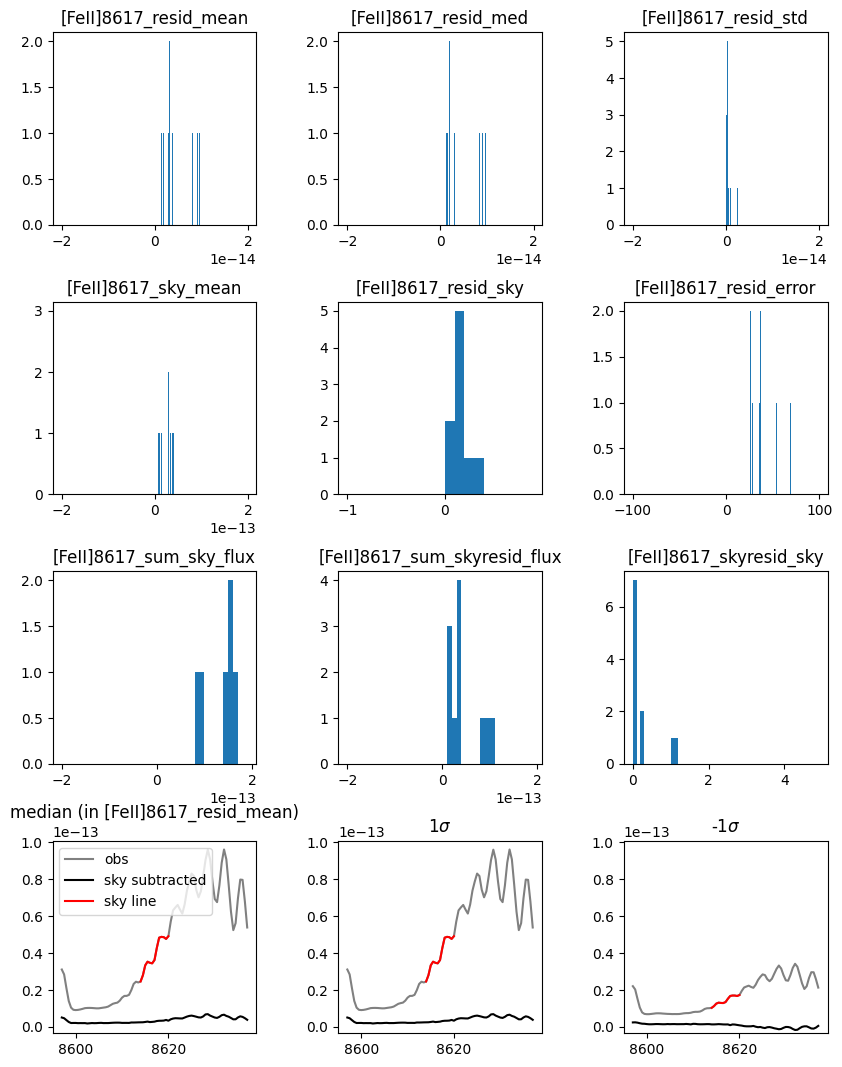

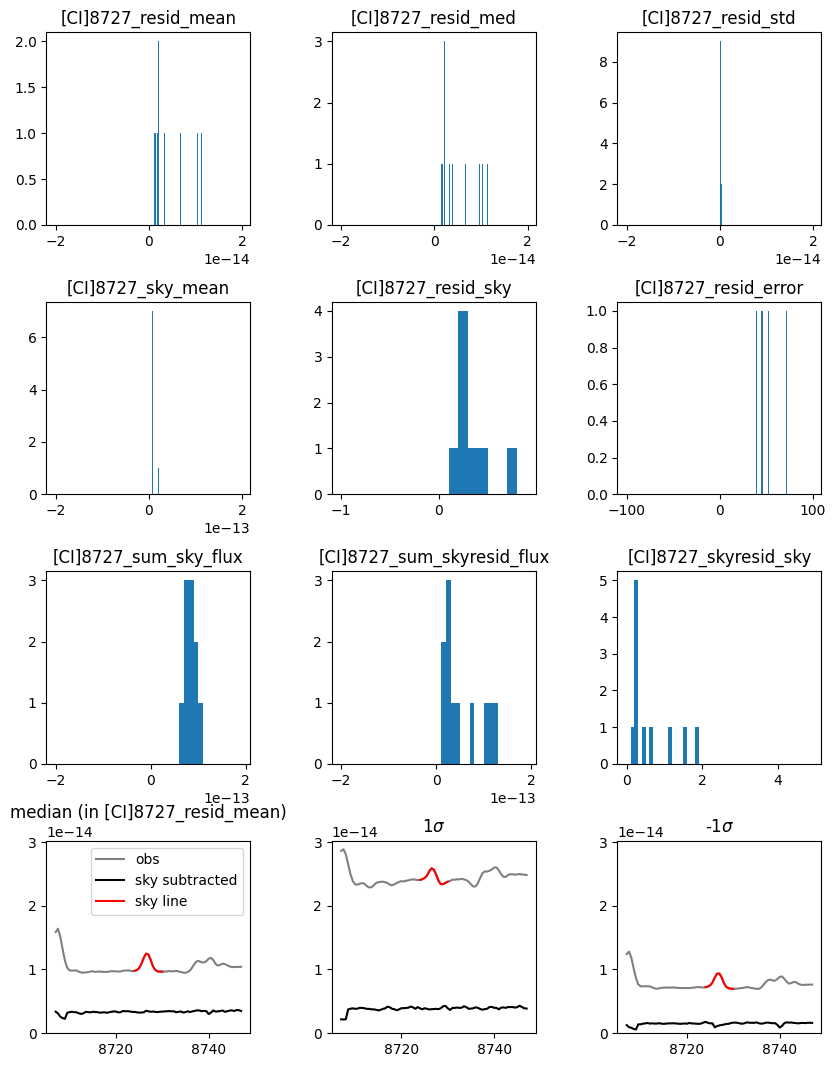

In [251]:
# metrics for the set of GCL tiles
expnums = [14042, #(the worst one), 
           20851, 20059, 20589, 14414, 14241, 14240, 14044, 21267, 14045, 20343 ]

sci_tiles = (drpall['tileid'] != 11111) & (np.abs(np.nanmax(flux,axis=1)) < 1e-12) & np.isin(drpall['expnum'], expnums)
# exclude the early science/non survey frames
# exclude things where the flux calibration failed
# pick specific exposure numbers

for i,which_line in enumerate(sky_list):
    make_plot(which_line, tab,wave,flux,sky,sci_tiles,'GCL_tiles')

for which_line in sci_lines:
    make_plot(which_line, tab,wave,flux,sky,sci_tiles, 'GCL_tiles',flag_sci=True)
